In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn
import os
import numpy as np
import random
import scipy
import sys

sys.path.append(os.path.join(os.path.dirname(
    os.path.abspath(''))))
import common.plots as plots

In [2]:
a = '32^3x24'
if a.find('x') != -1:
    b = a.split('x')
    space_size = int(b[0][:b[0].find('^')])
    time_size = int(b[1])
else:
    space_size = int(a[:a.find('^')])
    time_size = space_size
print(f'space size: {space_size}, time size: {time_size}')

space size: 32, time size: 24


In [3]:
fm_to_GeV = 1/0.197327
a = 0.048 * fm_to_GeV / 1000
print(1/a)

4110.979166666667


         HYP        PL  Nt  Ns    mu chain  conf     owner
0          0  0.002886  20  32  0.15    s0    50      Ilya
1          1  0.066551  20  32  0.15    s0    50      Ilya
2          2  0.121234  20  32  0.15    s0    50      Ilya
3          3  0.150182  20  32  0.15    s0    50      Ilya
4          4  0.171354  20  32  0.15    s0    50      Ilya
...      ...       ...  ..  ..   ...   ...   ...       ...
3650026    6  0.797172   6  32  0.00    s2  1000  Vladimir
3650027    7  0.804140   6  32  0.00    s2  1000  Vladimir
3650028    8  0.809253   6  32  0.00    s2  1000  Vladimir
3650029    9  0.812955   6  32  0.00    s2  1000  Vladimir
3650030   10  0.815738   6  32  0.00    s2  1000  Vladimir

[3650031 rows x 8 columns]
              T  Nt    mu  HYP        PL       err
0     64.234049  64  0.10   10  0.006541  0.001402
1     64.234049  64  0.30   10  0.006180  0.001050
2     64.234049  64  0.40   10  0.010330  0.001377
3    102.774479  40  0.15   10  0.008657  0.000919
4    102.

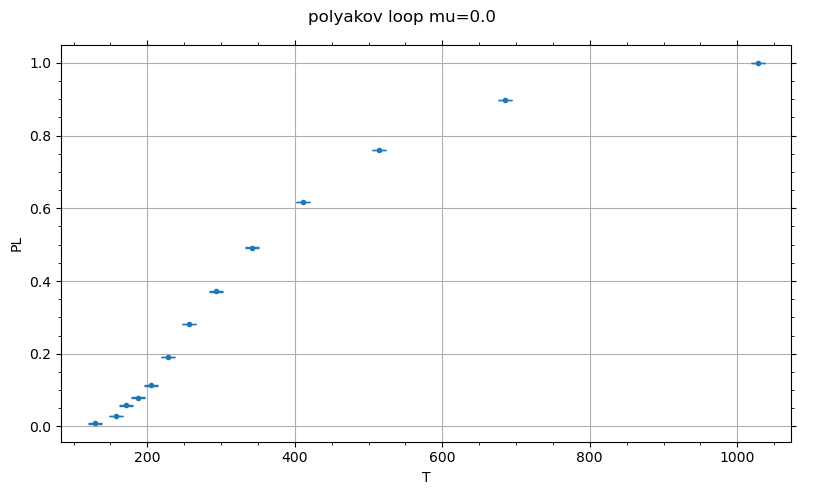

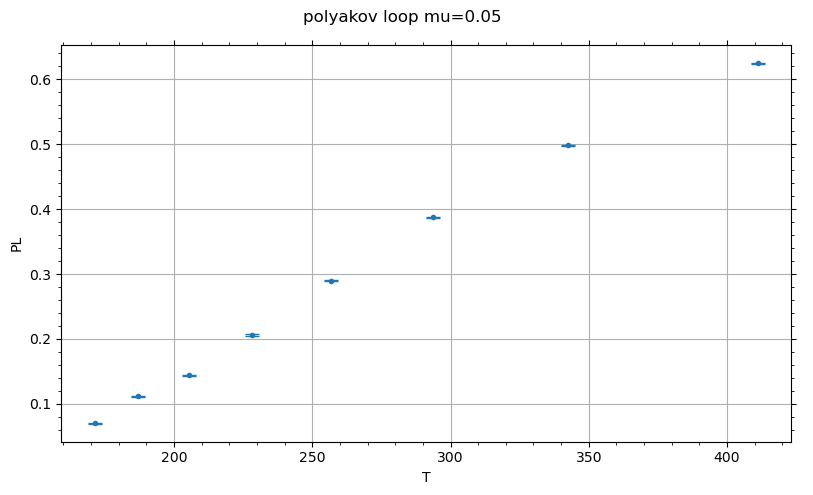

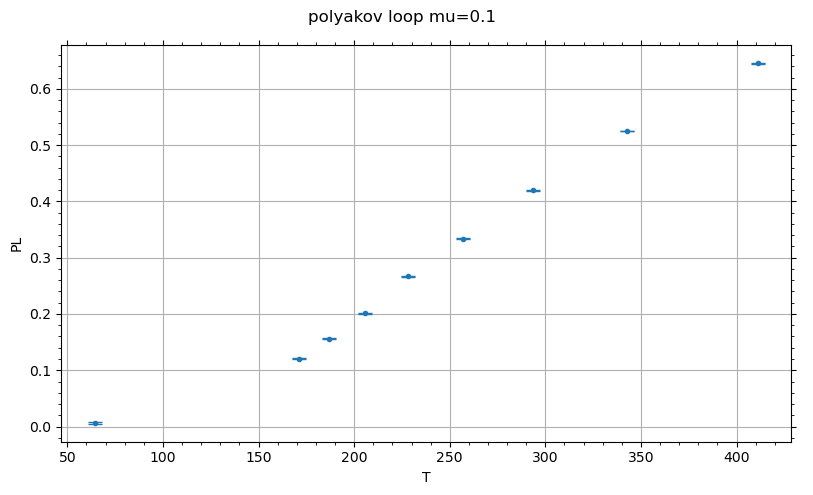

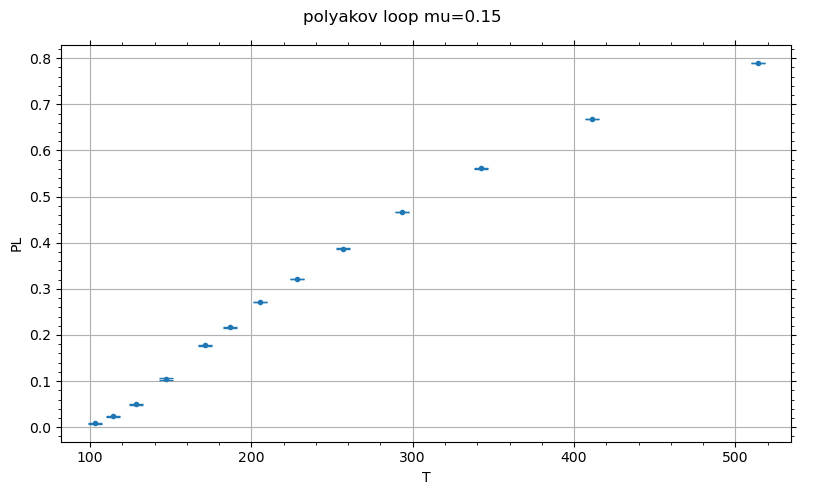

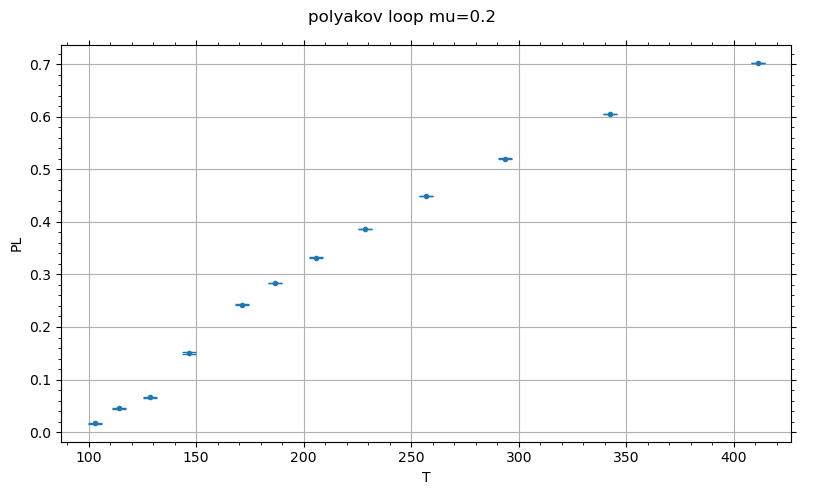

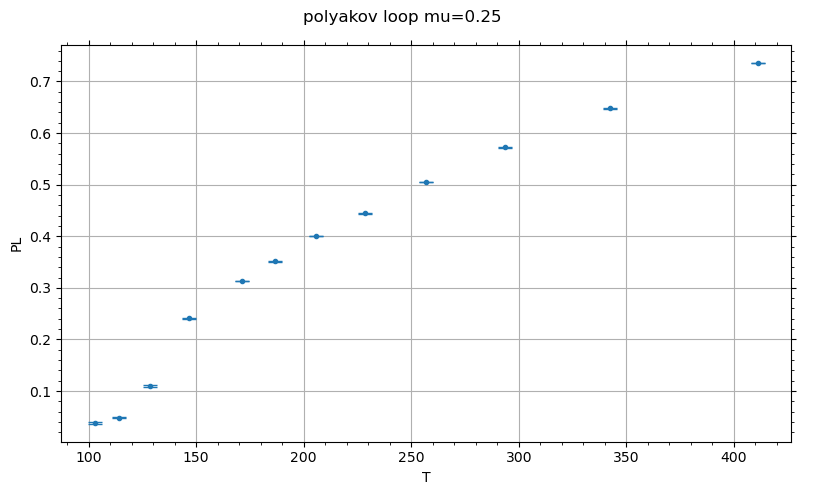

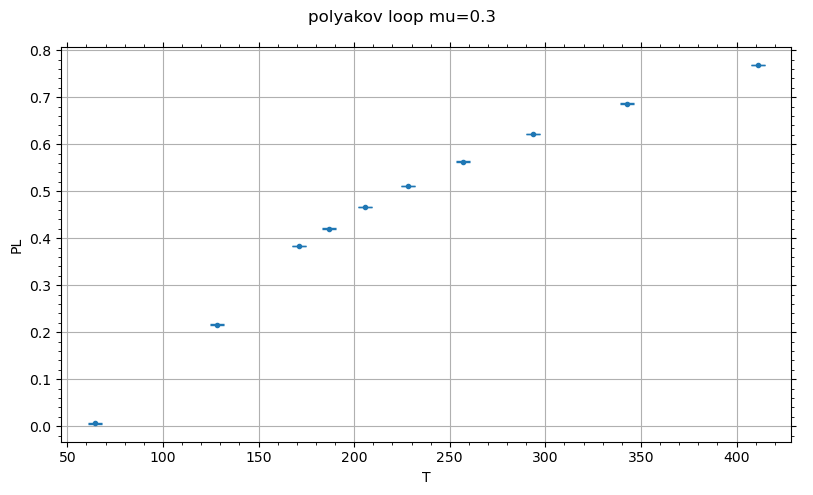

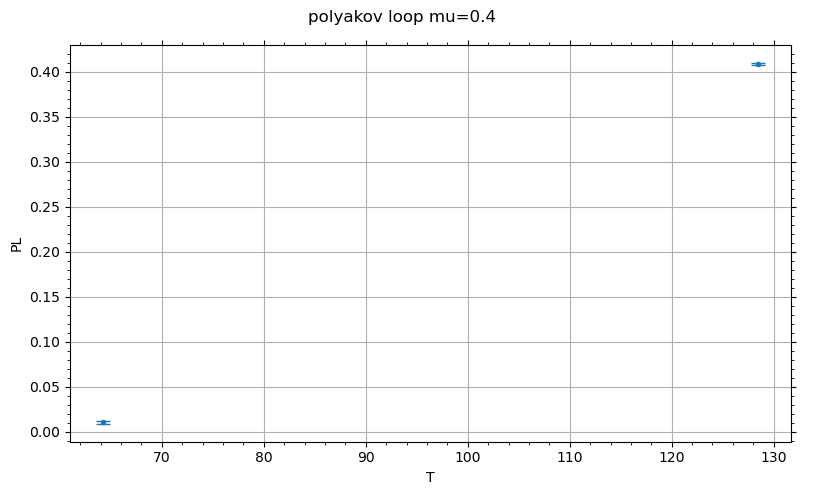

In [130]:
def plot_polyakov_loops(df):
    mu = df.name
    plots.plot_potential_single(df, 'T', 'PL', None, 'T', 'PL', f'polyakov loop mu={mu}', f'../../images/polyakov_loop/su2/qc2dstag/', f'polyakov_loop_mu={mu}', True, err='err')

df1 = pd.read_csv('/home/ilya/soft/lattice/observables/result/merged/polyakov_loop/polyakov_loops.csv')
df1['owner'] = 'Ilya'
df1 = df1[df1['Ns'] == 32]
df1 = df1[~df1['Nt'].isin([17, 19])]
# df1 = df1[~((df1['chain'] == 's0') & (df1['conf'] <= 200))]
df2 = pd.read_csv('/home/ilya/soft/lattice/observables/result/vladimir_data/merged/polyakov_loop/polyakov_loops.csv')
df2['owner'] = 'Vladimir'
df = pd.concat([df1, df2], ignore_index=True)
print(df)
df = df[df['HYP'] == 10]
fm_to_GeV = 1/0.197327
a = 0.048 * fm_to_GeV / 1000
df['T'] = 1 / (df['Nt'] * a)
df['PL'] = df['PL'] * (1.017 ** df['Nt'])
df_aver = df.groupby(['T', 'Nt', 'mu', 'HYP'])['PL']\
                      .agg([('PL', 'mean'), ('err', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index(level=['T', 'Nt', 'mu', 'HYP'])
print(df_aver)
df_aver.groupby(['mu']).apply(plot_polyakov_loops, include_groups=False)
df_aver.to_csv(f"../../result/polyakov_loop/su2/qc2dstag/polyakov_loops_all.csv", index=False)

In [1]:
# bootstrap for entropy
def entropy_sample(df, n_samples):
    T_arr = np.sort(df['T'].unique())
    T_middle = []
    sample_num = []
    entropy = []
    for i in range(n_samples):
        samples = []
        for j in range(len(T_arr)):
            samples.append(random.choices(df[df['T'] == T_arr[j]]['PL'].to_numpy(), k=df[df['T'] == T_arr[j]].shape[0]))
        means = []
        for j in range(len(T_arr)):
            means.append(np.mean(samples[j]))
        for j in range(len(T_arr) - 1):
            T_middle.append((T_arr[j] + T_arr[j + 1]) / 2)
            entropy.append((T_arr[j + 1] * np.log(means[j + 1]) - T_arr[j] * np.log(means[j])) / (T_arr[j + 1] - T_arr[j]))
            sample_num.append(i)
    return pd.DataFrame({'sample': sample_num, 'T': T_middle, 'entropy': entropy})

# bootstrap for susceptibility
def susceptibility_sample(df, n_samples):
    means = []
    sample_num = []
    data = df['PL'].to_numpy()
    n = df['PL'].shape[0]
    for i in range(n_samples):
        sample = random.choices(data, k=n)
        mean = np.mean(sample)
        sq_mean = 0
        for j in range(len(sample)):
            sq_mean += sample[j] ** 2
        means.append((sq_mean / len(sample) - mean ** 2))
        sample_num.append(i)
    return pd.DataFrame({'sample': sample_num, 'susceptibility': means})

# bootstrap for transition
def polyakov_loops_sample(df, n_samples):
    means = []
    sample_num = []
    data = df['PL'].to_numpy()
    n = df['PL'].shape[0]
    for i in range(n_samples):
        sample = random.choices(data, k=n)
        means.append(np.mean(sample))
        sample_num.append(i)
    return pd.DataFrame({'sample': sample_num, 'PL': means})

# def get_entropy()

def fit_gaussian(x, Tc, C, mu):
    return C * np.exp(-(x - Tc)**2 / (2 * mu ** 2))

def fit_samples_gaussian(df, x_col, y_col, p0):
    try:
        # print(df[x_col])
        # print(df[y_col])
        popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df[x_col], df[y_col], p0=p0)
        transition = popt[0]
        sigma = popt[2]
    except RuntimeError or RuntimeError:
        transition = np.nan
        sigma = np.nan
    return pd.DataFrame({'transition': [transition], 'sigma': [sigma]})

def fit_polinom_3(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def fit_samples_3(df, x_col, y_col):
    popt, pcov = scipy.optimize.curve_fit(fit_polinom_3, df[x_col], df[y_col])
    return pd.DataFrame({'transition': [-popt[1]/3/popt[0]]})

def fit_polinom_4(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

def fit_samples_4(df, x_col, y_col):
    popt, pcov = scipy.optimize.curve_fit(fit_polinom_4, df[x_col], df[y_col])
    try:
        transition_temperature1 = (-6 * popt[1] + math.sqrt(36 * popt[1]**2 - 96 * popt[0] * popt[2])) / (24 * popt[0])
        transition_temperature2 = (-6 * popt[1] - math.sqrt(36 * popt[1]**2 - 96 * popt[0] * popt[2])) / (24 * popt[0])
    except ValueError:
        transition_temperature1 = np.nan
        transition_temperature2 = np.nan
    return pd.DataFrame({'transition1': [transition_temperature1], 'transition2': [transition_temperature2]})

In [131]:
# average for susceptibility
df1 = pd.read_csv('/home/ilya/soft/lattice/observables/result/merged/polyakov_loop/polyakov_loops.csv')
df1['owner'] = 'Ilya'
df1 = df1[df1['Ns'] == 32]
df1 = df1[~df1['Nt'].isin([17, 19])]
# df1 = df1[~((df1['chain'] == 's0') & (df1['conf'] <= 200))]
df2 = pd.read_csv('/home/ilya/soft/lattice/observables/result/vladimir_data/merged/polyakov_loop/polyakov_loops.csv')
df2['owner'] = 'Vladimir'
df = pd.concat([df1, df2], ignore_index=True)
df = df[df['HYP'] == 10]
fm_to_GeV = 1/0.197327
a = 0.048 * fm_to_GeV / 1000
df['T'] = 1 / (df['Nt'] * a)
df['PL'] = df['PL'] * (1.017 ** df['Nt'])
print(np.sort(df['T'].unique()))
print(df)
df = df.groupby(['T', 'Nt', 'mu', 'HYP']).apply(susceptibility_sample, 5000, include_groups=False).reset_index(level=['T', 'Nt', 'mu', 'HYP'])
# print(df)
df1 = df.groupby(['T', 'Nt', 'mu', 'HYP'])['susceptibility']\
                  .agg([('susceptibility', 'mean'), ('err', lambda x: np.std(x, ddof=0))]).reset_index(level=['T', 'Nt', 'mu', 'HYP'])
print(df1)
df1.to_csv(f"../../result/polyakov_loop/su2/qc2dstag/susceptibility.csv", index=False)

[  64.23404948  102.77447917  114.19386574  128.46809896  146.82068452
  158.11458333  171.29079861  186.86268939  205.54895833  228.38773148
  256.93619792  293.64136905  342.58159722  411.09791667  513.87239583
  685.16319444 1027.74479167]
         HYP        PL  Nt  Ns    mu chain  conf     owner           T
10        10  0.313916  20  32  0.15    s0    50      Ilya  205.548958
21        10  0.263290  20  32  0.15    s0    51      Ilya  205.548958
32        10  0.261647  20  32  0.15    s0    52      Ilya  205.548958
43        10  0.282644  20  32  0.15    s0    53      Ilya  205.548958
54        10  0.315011  20  32  0.15    s0    54      Ilya  205.548958
...      ...       ...  ..  ..   ...   ...   ...       ...         ...
3649986   10  0.873657   6  32  0.00    s2   996  Vladimir  685.163194
3649997   10  0.896314   6  32  0.00    s2   997  Vladimir  685.163194
3650008   10  0.903728   6  32  0.00    s2   998  Vladimir  685.163194
3650019   10  0.908448   6  32  0.00    s2   99

In [132]:
# average for entropy
df1 = pd.read_csv('/home/ilya/soft/lattice/observables/result/merged/polyakov_loop/polyakov_loops.csv')
df1['owner'] = 'Ilya'
df1 = df1[df1['Ns'] == 32]
df1 = df1[~df1['Nt'].isin([17, 19])]
# df1 = df1[~((df1['chain'] == 's0') & (df1['conf'] <= 200))]
df2 = pd.read_csv('/home/ilya/soft/lattice/observables/result/vladimir_data/merged/polyakov_loop/polyakov_loops.csv')
df2['owner'] = 'Vladimir'
df = pd.concat([df1, df2], ignore_index=True)
df = df[df['HYP'] == 10]
fm_to_GeV = 1/0.197327
a = 0.048 * fm_to_GeV / 1000
df['T'] = 1 / (df['Nt'] * a)
df['PL'] = df['PL'] * (1.017 ** df['Nt'])
print(np.sort(df['T'].unique()))
print(df)
df = df.groupby(['mu']).apply(entropy_sample, 5000)
# print(df)
df1 = df.groupby(['T', 'mu'])['entropy']\
                  .agg([('entropy', 'mean'), ('err', lambda x: np.std(x, ddof=0))]).reset_index(level=['T', 'mu'])
print(df1)
df1.to_csv(f"../../result/polyakov_loop/su2/qc2dstag/entropy.csv", index=False)

[  64.23404948  102.77447917  114.19386574  128.46809896  146.82068452
  158.11458333  171.29079861  186.86268939  205.54895833  228.38773148
  256.93619792  293.64136905  342.58159722  411.09791667  513.87239583
  685.16319444 1027.74479167]
         HYP        PL  Nt  Ns    mu chain  conf     owner           T
10        10  0.313916  20  32  0.15    s0    50      Ilya  205.548958
21        10  0.263290  20  32  0.15    s0    51      Ilya  205.548958
32        10  0.261647  20  32  0.15    s0    52      Ilya  205.548958
43        10  0.282644  20  32  0.15    s0    53      Ilya  205.548958
54        10  0.315011  20  32  0.15    s0    54      Ilya  205.548958
...      ...       ...  ..  ..   ...   ...   ...       ...         ...
3649986   10  0.873657   6  32  0.00    s2   996  Vladimir  685.163194
3649997   10  0.896314   6  32  0.00    s2   997  Vladimir  685.163194
3650008   10  0.903728   6  32  0.00    s2   998  Vladimir  685.163194
3650019   10  0.908448   6  32  0.00    s2   99

/tmp/ipykernel_892/3421500163.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['mu']).apply(entropy_sample, 5000)


In [81]:
def transition_entropy(mu, HYP, T_borders, p0):
    df1 = pd.read_csv('/home/ilya/soft/lattice/observables/result/merged/polyakov_loop/polyakov_loops.csv')
    df1['owner'] = 'Ilya'
    df1 = df1[df1['Ns'] == 32]
    df1 = df1[~df1['Nt'].isin([17, 19])]
    # df1 = df1[~((df1['chain'] == 's0') & (df1['conf'] <= 200))]
    df2 = pd.read_csv('/home/ilya/soft/lattice/observables/result/vladimir_data/merged/polyakov_loop/polyakov_loops.csv')
    df2['owner'] = 'Vladimir'
    df = pd.concat([df1, df2], ignore_index=True)
    df = df[df['mu'] == mu]
    df = df[df['HYP'] == HYP]
    fm_to_GeV = 1/0.197327
    a = 0.048 * fm_to_GeV / 1000
    df['T'] = 1 / (df['Nt'] * a)
    df_aver = df.groupby(['T', 'Nt'])['PL']\
                      .agg([('PL', 'mean'), ('err', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index(level=['T', 'Nt'])
    # print(df_aver)
    df['PL'] = df['PL'] * (1.017 ** df['Nt'])
    print(np.sort(df['T'].unique()))
    # print(df)
    df = entropy_sample(df, 5000)
    # print(df)
    df1 = df.groupby(['T'])['entropy']\
                      .agg([('entropy', 'mean'), ('err', lambda x: np.std(x, ddof=0))]).reset_index(level=['T'])
    df = df[df['T'] > T_borders[0]]
    df = df[df['T'] < T_borders[1]]
    print(np.sort(df['T'].unique()))
    plots.plot_potential_single(df1, 'T', 'entropy', None, 'T', 'entropy', 'entropy', f'../../images/potential/su2/qc2dstag/', 'polyakov loop', True, err='err')
    df_transition = df.groupby(['sample']).apply(fit_samples_gaussian, 'T', 'entropy', p0, include_groups=False).reset_index(level='sample')
    df_transition = df_transition.dropna()
    print(df_transition)
    df1 = df1[df1['T'] > T_borders[0]]
    df1 = df1[df1['T'] < T_borders[1]]
    popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df1['T'], df1['entropy'], p0=p0)
    print(popt)
    x_fit = np.linspace(T_borders[0] - 20, T_borders[1] + 20, 1000)
    y_fit = fit_gaussian(x_fit, *popt)
    df_fit = pd.DataFrame({'T': x_fit, 'entropy': y_fit})
    df_fit['fit'] = 'fit'
    df1['fit'] = 'fit'
    # print(df)
    plots.plot_potential_single(df1, 'T', 'entropy', 'fit', 'T', 'entropy', 'entropy', f'../../images/potential/su2/qc2dstag/', 'polyakov loop', True, err='err', df_fits=df_fit)
    print(df_transition['transition'].mean(), df_transition['transition'].std(ddof=0))
    return pd.DataFrame({'mu': [mu], 'transition': [df_transition['transition'].mean()], 'transition_err': [df_transition['transition'].std(ddof=0)], 'sigma': df_transition['sigma'].mean()})

[ 128.46809896  158.11458333  171.29079861  186.86268939  205.54895833
  228.38773148  256.93619792  293.64136905  342.58159722  411.09791667
  513.87239583  685.16319444 1027.74479167]
[196.20582386 216.96834491 242.6619647 ]


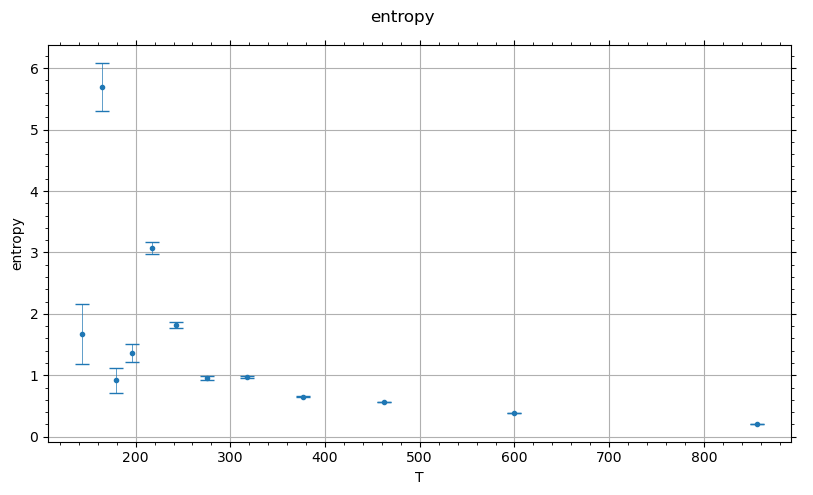

/tmp/ipykernel_892/2609634035.py:57: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df[x_col], df[y_col], p0=p0)


    sample  transition      sigma
0        0  222.232329  18.387161
0        1  223.192788  18.494165
0        2  222.777714  18.770733
0        3  221.777274  20.826531
0        4  221.202422  21.958956
..     ...         ...        ...
0     4995  222.107102  20.413050
0     4996  222.142827  18.993045
0     4997  222.433399  18.385654
0     4998  221.524925  18.989767
0     4999  222.189503  18.241644

[5000 rows x 3 columns]
[221.89312821   3.16356589  19.77676907]


/tmp/ipykernel_892/4221894974.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df1['T'], df1['entropy'], p0=p0)


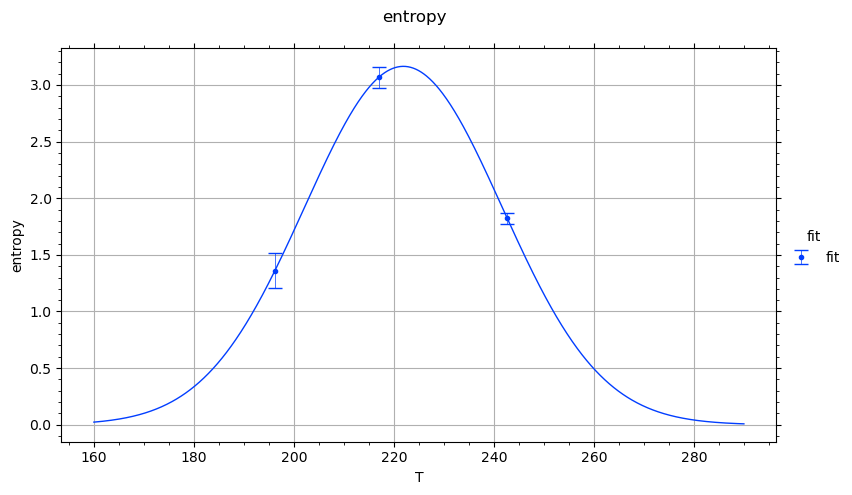

221.86814509832942 0.7350341283857305


In [82]:
df_e_0_3p = transition_entropy(0, 10, (180, 270), [220, 2, 20])

[ 128.46809896  158.11458333  171.29079861  186.86268939  205.54895833
  228.38773148  256.93619792  293.64136905  342.58159722  411.09791667
  513.87239583  685.16319444 1027.74479167]
[179.076744   196.20582386 216.96834491 242.6619647 ]


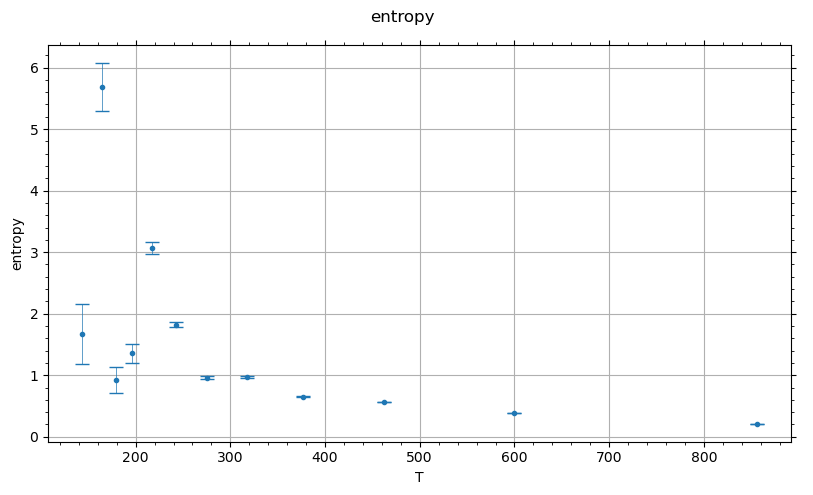

    sample  transition      sigma
0        0  220.568727  20.937421
0        1  219.904411  20.975019
0        2  220.250331  23.232472
0        3  220.359580  23.947623
0        4  220.501205  21.826180
..     ...         ...        ...
0     4995  221.674762  25.031275
0     4996  220.510188  22.774730
0     4997  220.660631  22.348511
0     4998  219.551676  28.028514
0     4999  220.629114  21.684341

[5000 rows x 3 columns]
[220.83652995   2.96799442  22.86506256]


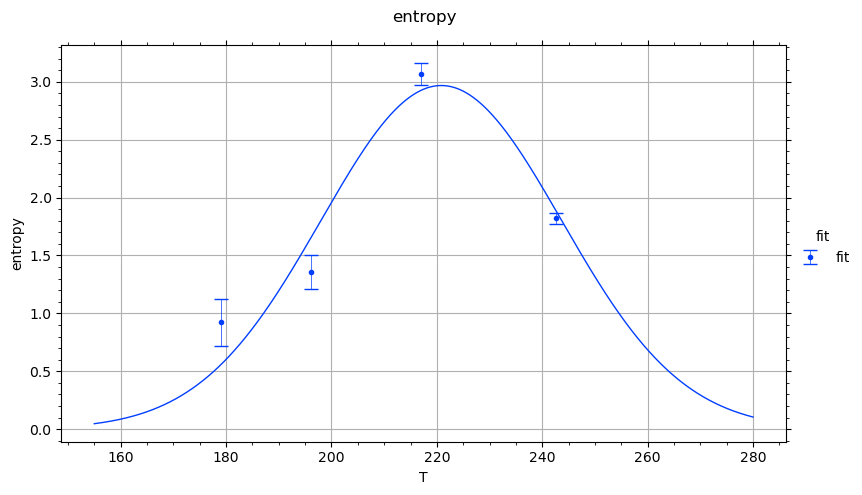

220.83771430474116 0.6381542379012016


In [135]:
df_e_0_4p = transition_entropy(0, 10, (175, 260), [220, 2, 20])

[171.29079861 186.86268939 205.54895833 228.38773148 256.93619792
 293.64136905 342.58159722 411.09791667]
[196.20582386 216.96834491 242.6619647 ]


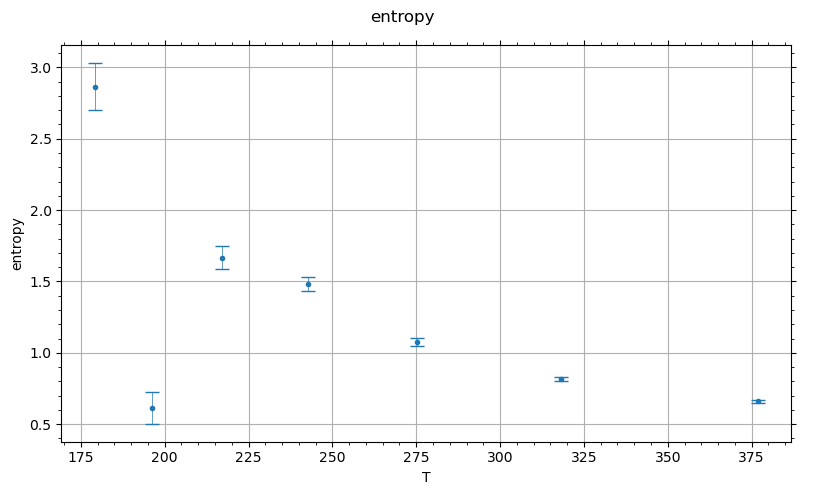

/tmp/ipykernel_892/2609634035.py:57: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df[x_col], df[y_col], p0=p0)


    sample  transition      sigma
0        0  228.588168  19.636524
0        1  228.193120  19.178966
0        2  227.961183  18.522205
0        3  227.949461  23.215480
0        4  228.288226  19.056198
..     ...         ...        ...
0     4995  228.280074  22.341771
0     4996  228.061402  23.486418
0     4997  230.393837  26.346482
0     4998  228.661853  20.649688
0     4999  227.863703  21.031892

[5000 rows x 3 columns]
[227.80878756   1.90472677  20.98387118]


/tmp/ipykernel_892/4221894974.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df1['T'], df1['entropy'], p0=p0)


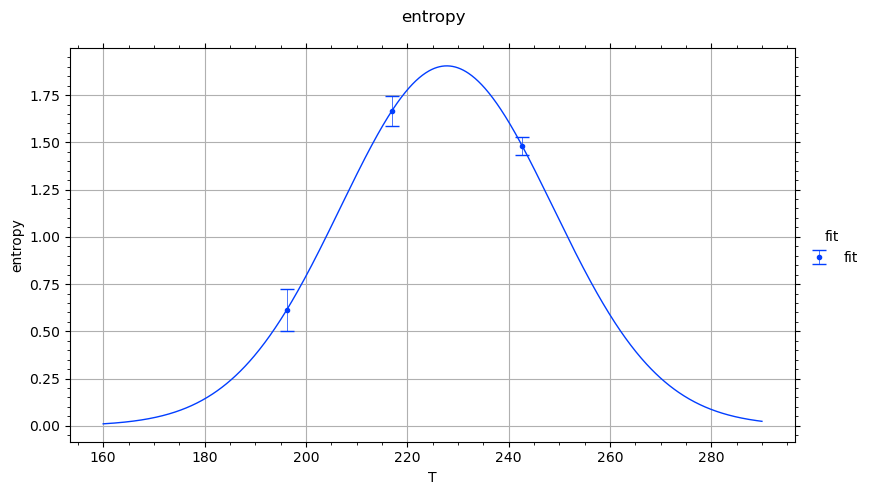

227.942197157581 1.0649074390233033


In [84]:
df_e_0p05_3p = transition_entropy(0.05, 10, (180, 270), [220, 2, 20])

[171.29079861 186.86268939 205.54895833 228.38773148 256.93619792
 293.64136905 342.58159722 411.09791667]
[196.20582386 216.96834491 242.6619647  275.28878348]


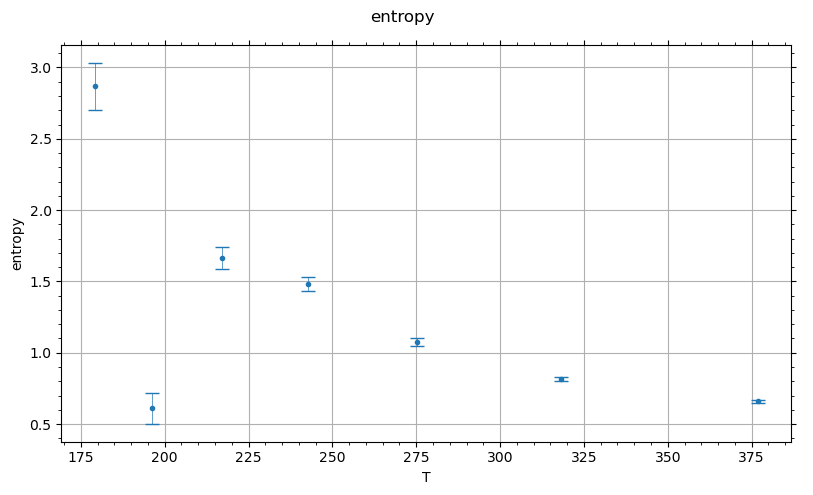

    sample  transition      sigma
0        0  238.372177  36.621994
0        1  240.498443  36.853825
0        2  240.173800  36.376846
0        3  237.675811  35.448222
0        4  241.793424  35.095916
..     ...         ...        ...
0     4995  238.632414  34.348974
0     4996  238.049616  35.675444
0     4997  240.051703  36.200847
0     4998  238.661549  36.145213
0     4999  238.679770  34.360934

[5000 rows x 3 columns]
[239.04078703   1.67930672  35.42702094]


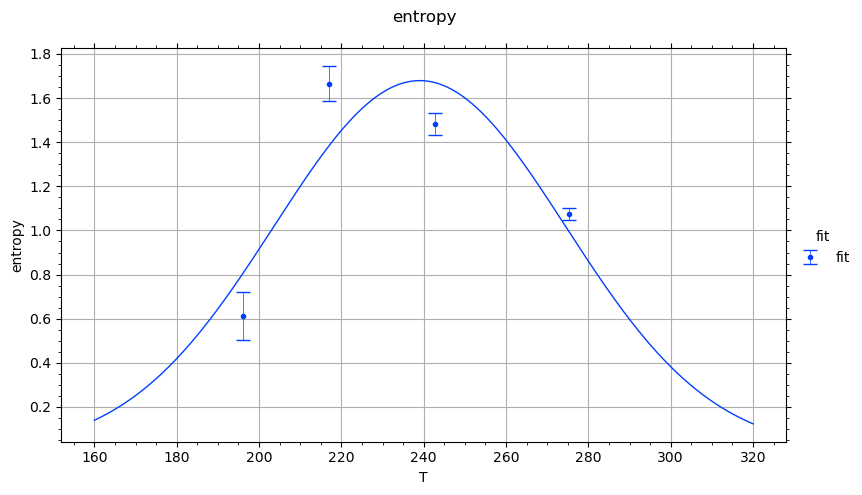

238.98635302703073 1.0542601780986167


In [85]:
df_e_0p05_4p = transition_entropy(0.05, 10, (180, 300), [220, 2, 20])

[ 64.23404948 171.29079861 186.86268939 205.54895833 228.38773148
 256.93619792 293.64136905 342.58159722 411.09791667]
[196.20582386 216.96834491 242.6619647 ]


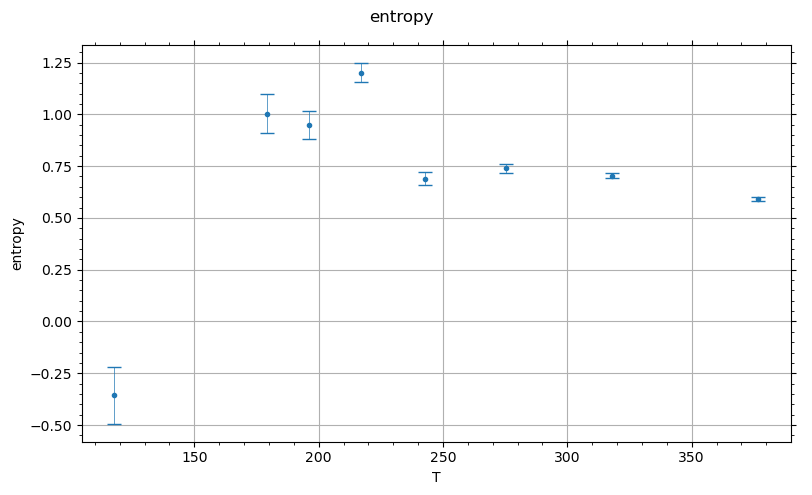

/tmp/ipykernel_892/2609634035.py:57: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df[x_col], df[y_col], p0=p0)


    sample  transition      sigma
0        0  212.302616  27.204024
0        1  215.320349  25.867142
0        2  215.888759  24.016112
0        3  214.302812  25.395014
0        4  212.263336  28.933662
..     ...         ...        ...
0     4995  214.610894  25.010241
0     4996  213.948594  27.681614
0     4997  210.365023  31.996615
0     4998  217.336142  24.248298
0     4999  215.430453  26.766853

[5000 rows x 3 columns]
[214.57387411   1.20574227  26.54750267]


/tmp/ipykernel_892/4221894974.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df1['T'], df1['entropy'], p0=p0)


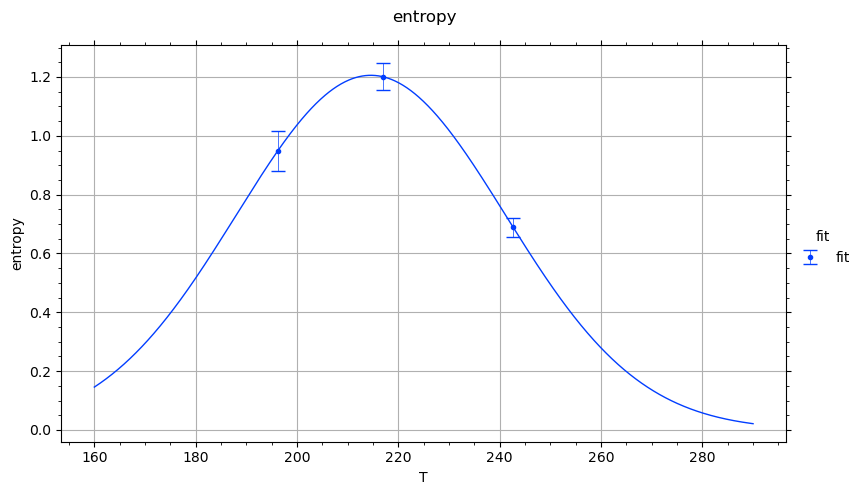

214.2670110013383 2.2985234646712596


In [86]:
df_e_0p1_3p = transition_entropy(0.1, 10, (180, 270), [220, 2, 20])

[ 64.23404948 171.29079861 186.86268939 205.54895833 228.38773148
 256.93619792 293.64136905 342.58159722 411.09791667]
[179.076744   196.20582386 216.96834491 242.6619647 ]


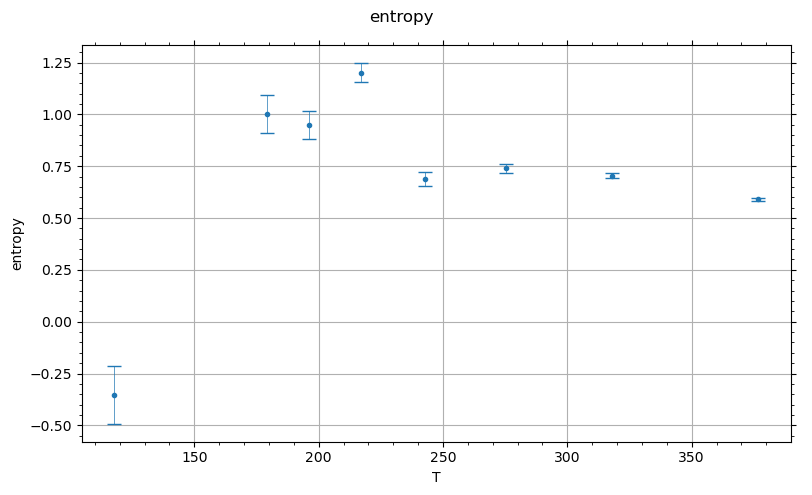

    sample  transition      sigma
0        0  209.687018  31.612975
0        1  202.522453  39.907892
0        2  188.099415  58.828160
0        3  209.516261  31.915652
0        4  206.194095  41.235001
..     ...         ...        ...
0     4995  204.356757  40.281579
0     4996  203.238750  45.559319
0     4997  208.606559  41.348148
0     4998  207.766162  39.297875
0     4999  197.172370  48.750979

[4997 rows x 3 columns]
[204.5285075    1.12311671  41.56525369]


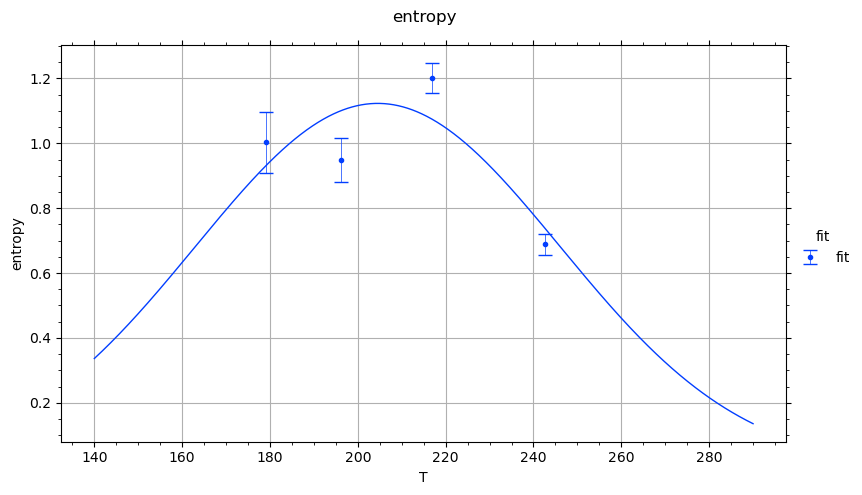

202.85568398353345 11.14554567966555


In [87]:
df_e_0p1_4p = transition_entropy(0.1, 10, (160, 270), [220, 2, 20])

[102.77447917 114.19386574 128.46809896 146.82068452 171.29079861
 186.86268939 205.54895833 228.38773148 256.93619792 293.64136905
 342.58159722 411.09791667 513.87239583]
[179.076744   196.20582386 216.96834491]


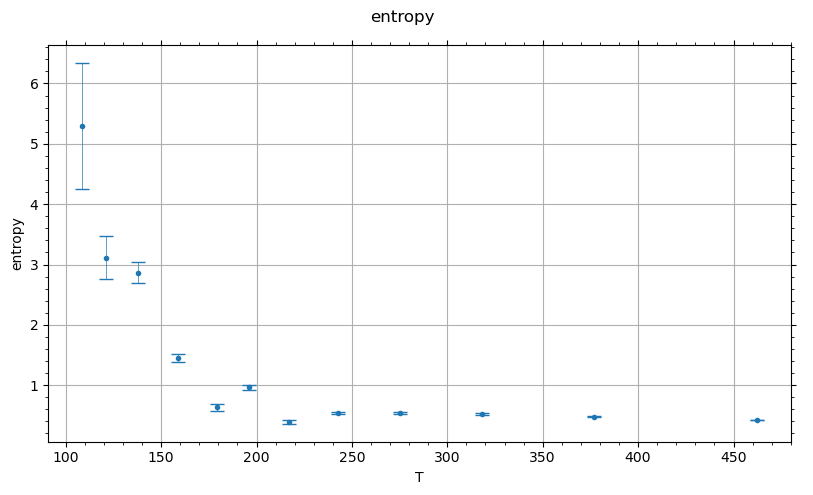

/tmp/ipykernel_892/2609634035.py:57: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df[x_col], df[y_col], p0=p0)


    sample  transition      sigma
0        0  195.158637  15.823070
0        1  193.827810  17.261394
0        2  195.729694  16.296503
0        3  194.251124  16.738718
0        4  195.133366  15.864674
..     ...         ...        ...
0     4995  195.326057  16.744990
0     4996  193.992456  17.793004
0     4997  191.077914  18.853224
0     4998  194.735455  16.478085
0     4999  195.321316  15.768583

[5000 rows x 3 columns]
[194.49049387   0.96913521  16.67119069]


/tmp/ipykernel_892/4221894974.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df1['T'], df1['entropy'], p0=p0)


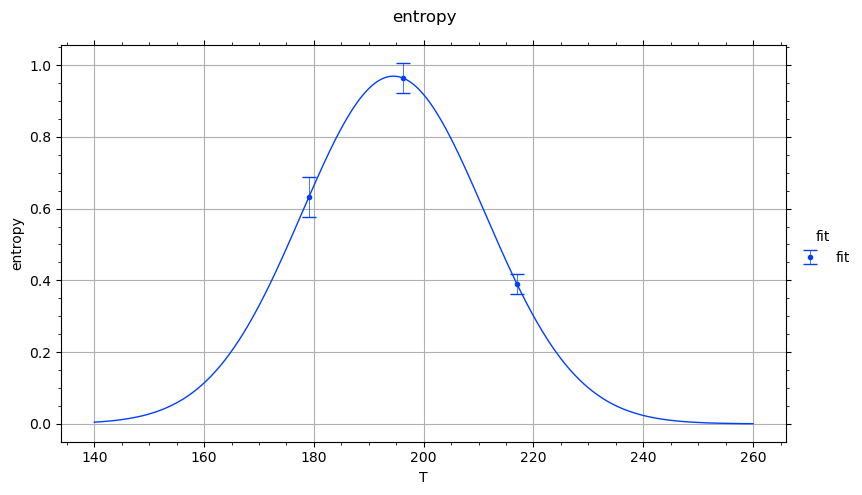

194.39664133367003 1.1444757866361024


In [ ]:
df_e_0p15_3p = transition_entropy(0.15, 10, (160, 240), [180, 1, 20])

[102.77447917 114.19386574 128.46809896 146.82068452 171.29079861
 186.86268939 205.54895833 228.38773148 256.93619792 293.64136905
 342.58159722 411.09791667 513.87239583]
[159.05574157 179.076744   196.20582386 216.96834491 242.6619647 ]


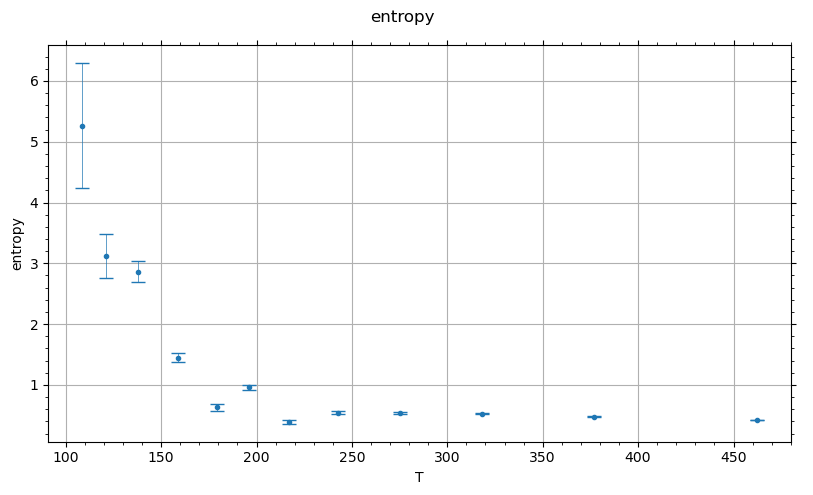

Empty DataFrame
Columns: [sample, transition, sigma]
Index: []


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [ ]:
df_e_0p15_4p = transition_entropy(0.15, 10, (150, 250), [180, 1, 20])

[102.77447917 114.19386574 128.46809896 146.82068452 171.29079861
 186.86268939 205.54895833 228.38773148 256.93619792 293.64136905
 342.58159722 411.09791667]
[121.33098235 137.64439174 159.05574157]


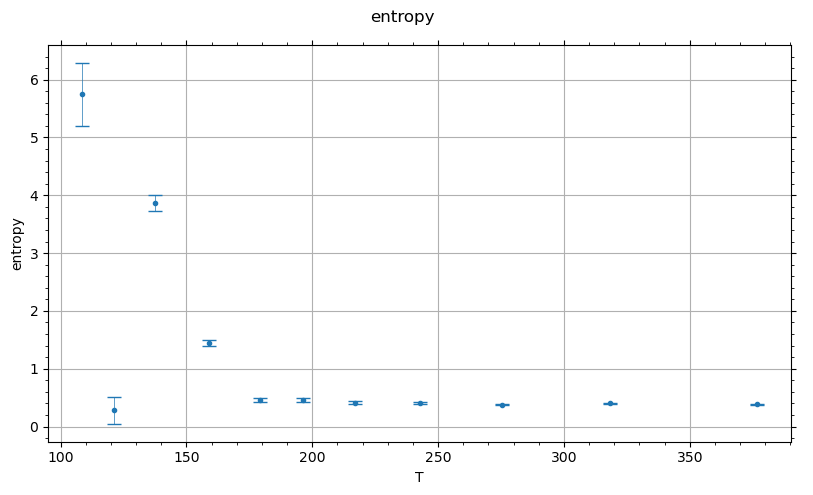

/tmp/ipykernel_892/2609634035.py:57: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df[x_col], df[y_col], p0=p0)


    sample  transition      sigma
0        0  142.621642  11.404131
0        2  145.083781   8.127074
0        3  143.872512   9.685756
0        4  144.237594   9.561435
0        5  145.147810   8.470963
..     ...         ...        ...
0     4995  144.442142  10.042963
0     4996  144.600935   8.355522
0     4997  145.959308  -6.997838
0     4998  143.962734   9.853015
0     4999  144.131708   9.602363

[4485 rows x 3 columns]
[144.1477898    4.86897002   9.56918246]


/tmp/ipykernel_892/4221894974.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df1['T'], df1['entropy'], p0=p0)


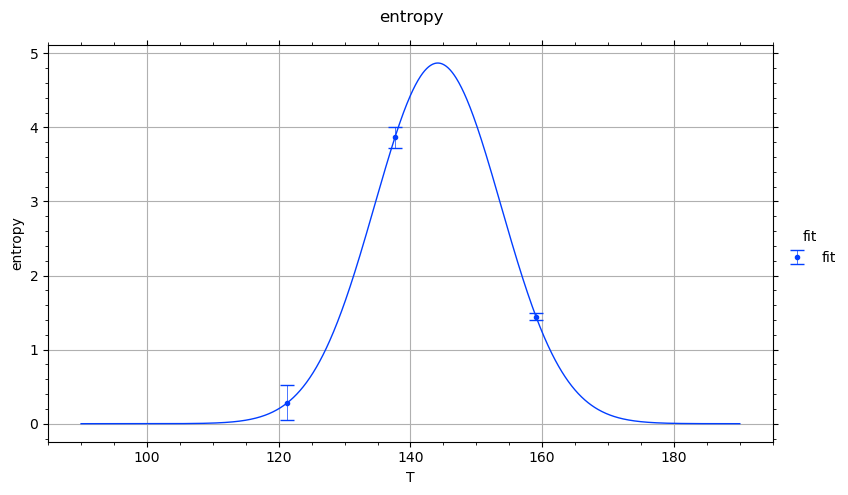

144.07223590921546 0.9644445042404395


In [139]:
df_e_0p2_3p = transition_entropy(0.2, 10, (110, 170), [190, 0.5, 30])

[102.77447917 114.19386574 128.46809896 146.82068452 171.29079861
 186.86268939 205.54895833 228.38773148 256.93619792 293.64136905
 342.58159722 411.09791667]
[121.33098235 137.64439174 159.05574157 179.076744  ]


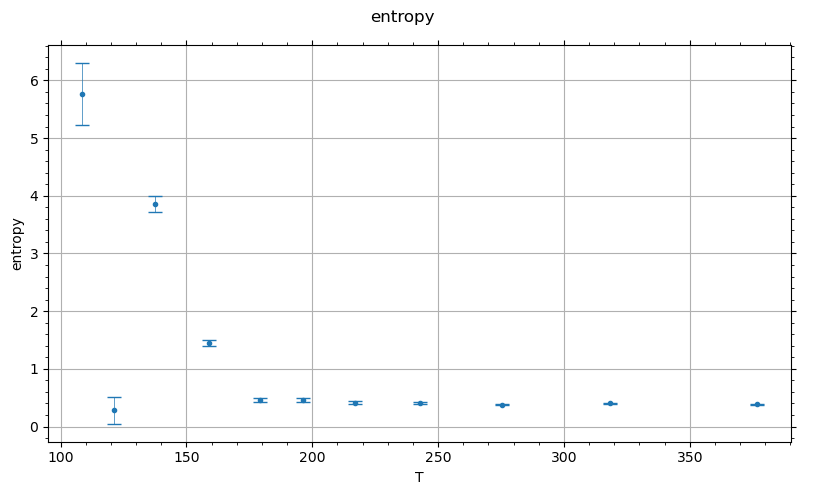

/tmp/ipykernel_892/2609634035.py:57: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df[x_col], df[y_col], p0=p0)


    sample  transition      sigma
0        0  144.443414   9.200255
0        1  143.475260  10.492646
0        2  144.215736   9.275724
0        3  143.174272  10.644152
0        4  143.753335  10.275020
..     ...         ...        ...
0     4994  142.526626  11.806774
0     4995  143.803500  10.053948
0     4996  144.131770   9.538165
0     4998  141.838307  11.582800
0     4999  143.270219 -10.588835

[4901 rows x 3 columns]
[144.09953563   4.82466957   9.65501281]


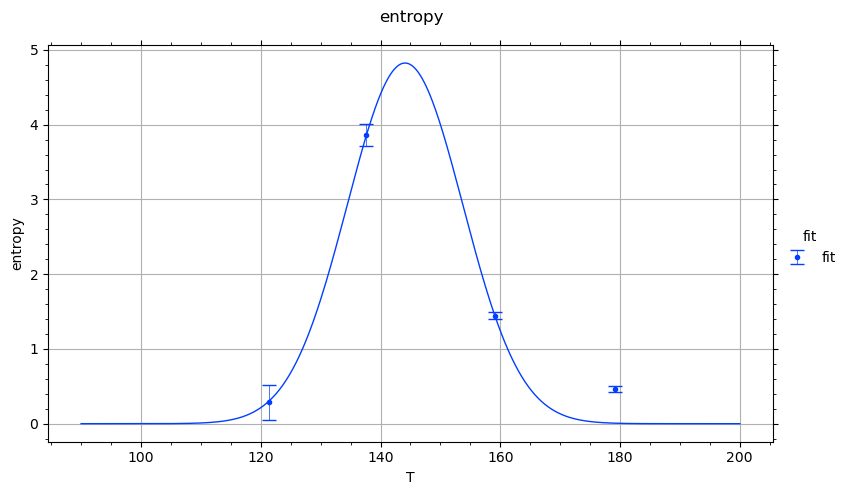

144.34485038596065 1.3093724394141297


In [140]:
df_e_0p2_4p = transition_entropy(0.2, 10, (110, 180), [190, 0.5, 30])

[102.77447917 114.19386574 128.46809896 146.82068452 171.29079861
 186.86268939 205.54895833 228.38773148 256.93619792 293.64136905
 342.58159722 411.09791667]
[108.48417245 121.33098235 137.64439174]


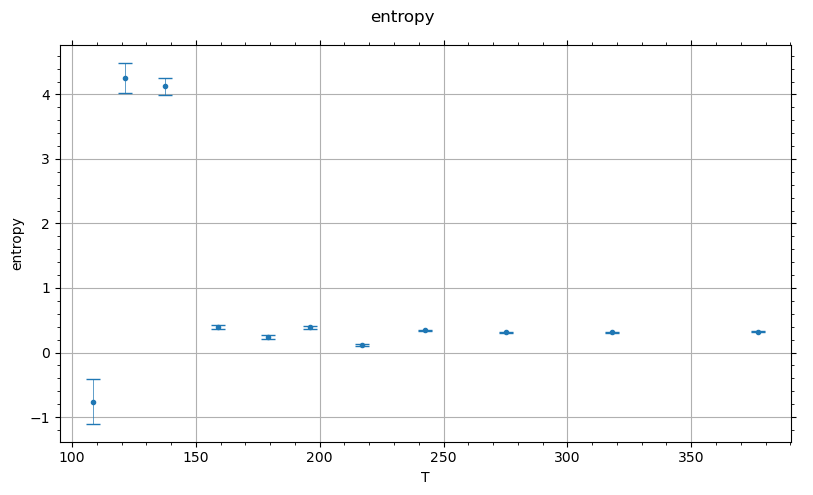

/tmp/ipykernel_892/2609634035.py:57: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df[x_col], df[y_col], p0=p0)


    sample  transition     sigma
0        3  129.448151  3.295773
0        4  129.506775  3.307271
0        5  129.507015  3.321135
0        8  129.516274  3.337777
0        9  129.545417  3.345337
..     ...         ...       ...
0     4992  129.489837  3.367154
0     4993  129.415541  3.296718
0     4994  129.529768  3.353302
0     4996  129.399006  3.364710
0     4999  129.417595  3.289182

[3725 rows x 3 columns]
[129.46634061  80.40952435   3.35556243]


/tmp/ipykernel_892/4221894974.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df1['T'], df1['entropy'], p0=p0)


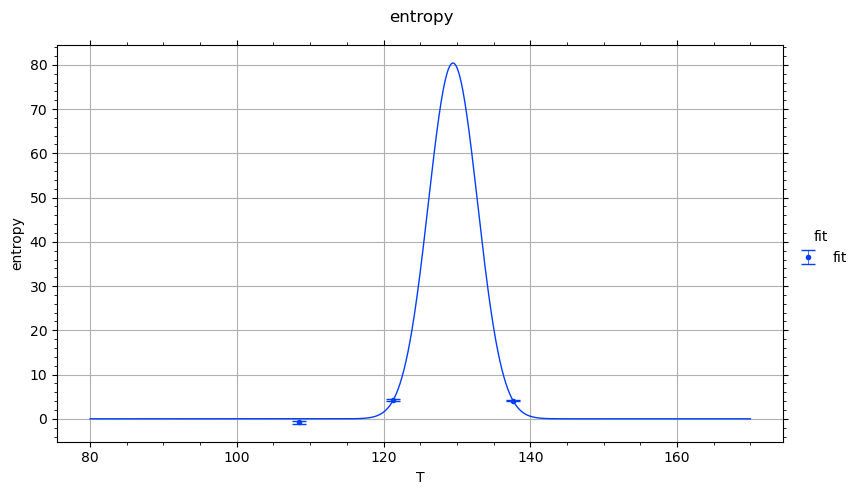

129.46403567123193 0.06686137223114481


In [141]:
df_e_0p25_3p = transition_entropy(0.25, 10, (100, 150), [190, 0.5, 30])

[102.77447917 114.19386574 128.46809896 146.82068452 171.29079861
 186.86268939 205.54895833 228.38773148 256.93619792 293.64136905
 342.58159722 411.09791667]
[108.48417245 121.33098235 137.64439174 159.05574157]


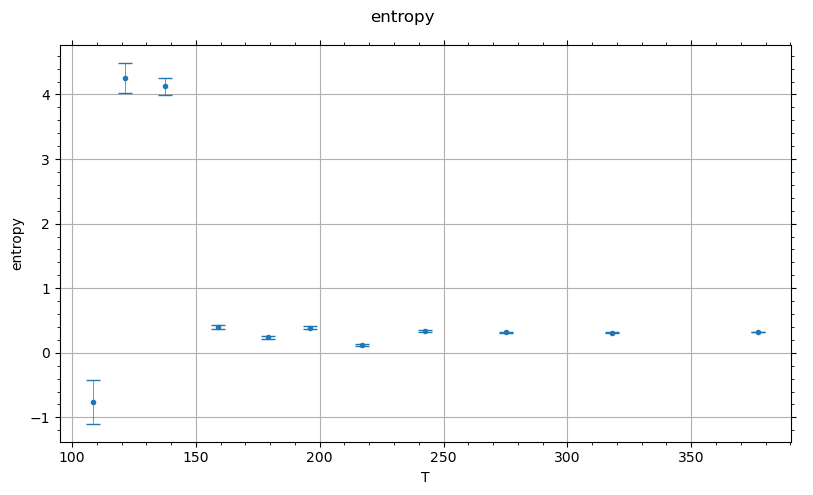

    sample  transition     sigma
0        0  129.582224  3.339674
0        3  129.530366 -3.323172
0        4  129.382621 -3.318301
0        5  129.524222 -6.450250
0        6  129.474756  3.295259
..     ...         ...       ...
0     4995  129.418186  3.317134
0     4996  129.437271 -3.298311
0     4997  129.459400  3.398899
0     4998  129.382542 -3.279562
0     4999  129.438345  3.319656

[4610 rows x 3 columns]
[129.46546519  75.58445185   3.39119036]


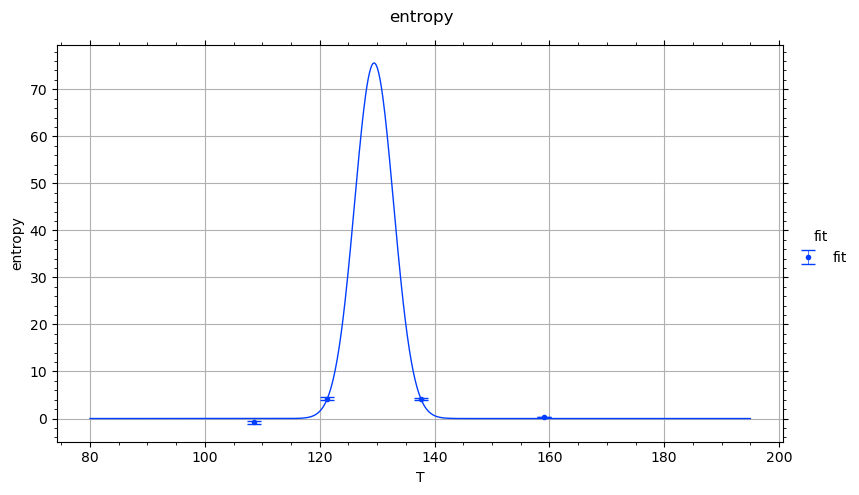

129.4663908328564 0.06460857076967103


In [142]:
df_e_0p25_4p = transition_entropy(0.25, 10, (100, 175), [190, 0.5, 30])

[ 64.23404948 128.46809896 171.29079861 186.86268939 205.54895833
 228.38773148 256.93619792 293.64136905 342.58159722 411.09791667]
[149.87944878]


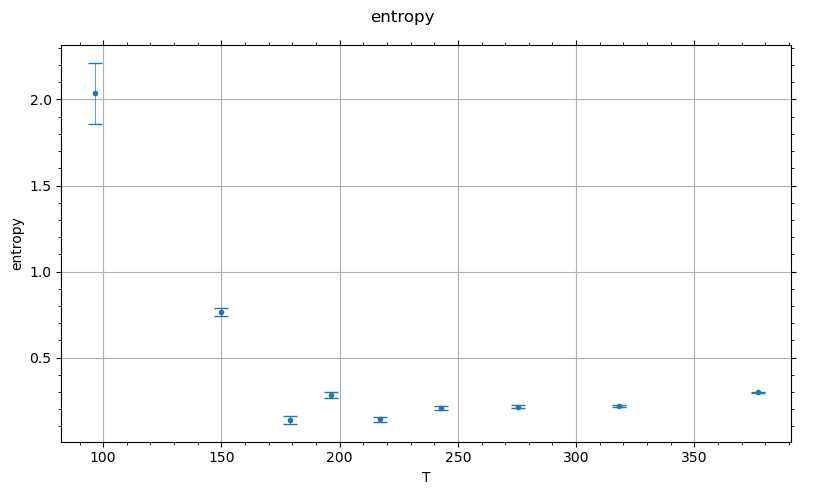

TypeError: Improper input: func input vector length N=3 must not exceed func output vector length M=1

In [143]:
df_e_0p3_3p = transition_entropy(0.30, 10, (100, 175), [190, 0.5, 30])

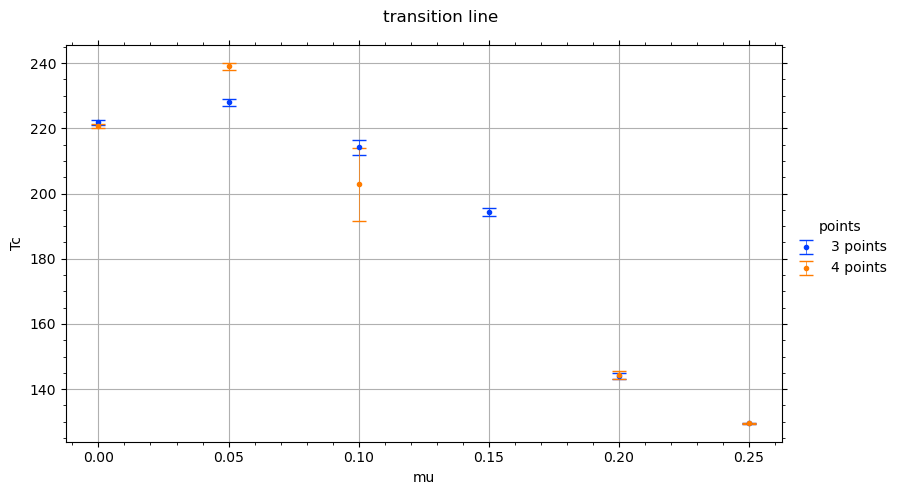

In [145]:
df_transition_line_3p = pd.concat([df_e_0_3p, df_e_0p05_3p, df_e_0p1_3p, df_e_0p15_3p, df_e_0p2_3p, df_e_0p25_3p])
df_transition_line_3p['points'] = '3 points'
df_transition_line_4p = pd.concat([df_e_0_4p, df_e_0p05_4p, df_e_0p1_4p, df_e_0p2_4p, df_e_0p25_4p])
df_transition_line_4p['points'] = '4 points'
df_transition_line_all = pd.concat([df_transition_line_3p, df_transition_line_4p])
# df_transition_line_all = df_transition_line_all[df_transition_line_all['mu'] < 0.2]
plots.plot_potential_single(df_transition_line_all, 'mu', 'transition', 'points', 'mu', 'Tc', 'transition line', f'../../images/potential/su2/qc2dstag/', 'transition_line', True, err='transition_err')

In [5]:
def transition_susceptibility(mu, HYP, T_borders, p0):
    df1 = pd.read_csv('/home/ilya/soft/lattice/observables/result/merged/polyakov_loop/polyakov_loops.csv')
    df1['owner'] = 'Ilya'
    df1 = df1[df1['Ns'] == 32]
    df1 = df1[~df1['Nt'].isin([17, 19])]
    # df1 = df1[~((df1['chain'] == 's0') & (df1['conf'] <= 200))]
    df2 = pd.read_csv('/home/ilya/soft/lattice/observables/result/vladimir_data/merged/polyakov_loop/polyakov_loops.csv')
    df2['owner'] = 'Vladimir'
    df = pd.concat([df1, df2], ignore_index=True)
    df = df[df['mu'] == mu]
    df = df[df['HYP'] == HYP]
    fm_to_GeV = 1/0.197327
    a = 0.048 * fm_to_GeV / 1000
    df['T'] = 1 / (df['Nt'] * a)
    df_aver = df.groupby(['T', 'Nt'])['PL']\
                      .agg([('PL', 'mean'), ('err', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index(level=['T', 'Nt'])
    # print(df_aver)
    df['PL'] = df['PL'] * (1.017 ** df['Nt'])
    print(np.sort(df['T'].unique()))
    # print(df)
    df = df.groupby(['T', 'Nt']).apply(susceptibility_sample, 5000, include_groups=False).reset_index(level=['T', 'Nt'])
    # print(df)
    df1 = df.groupby(['T'])['susceptibility']\
                      .agg([('susceptibility', 'mean'), ('err', lambda x: np.std(x, ddof=0))]).reset_index(level=['T'])
    df = df[df['T'] > T_borders[0]]
    df = df[df['T'] < T_borders[1]]
    print(np.sort(df['T'].unique()))
    plots.plot_potential_single(df1, 'T', 'susceptibility', None, 'T', 'susceptibility', 'susceptibility', f'../../images/potential/su2/qc2dstag/', 'polyakov loop', True, err='err')
    df_transition = df.groupby(['sample']).apply(fit_samples_gaussian, 'T', 'susceptibility', p0, include_groups=False).reset_index(level='sample')
    df_transition = df_transition.dropna()
    print(df_transition)
    df1 = df1[df1['T'] > T_borders[0]]
    df1 = df1[df1['T'] < T_borders[1]]
    popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df1['T'], df1['susceptibility'], p0=p0)
    print(popt)
    x_fit = np.linspace(T_borders[0] - 20, T_borders[1] + 20, 1000)
    y_fit = fit_gaussian(x_fit, *popt)
    df_fit = pd.DataFrame({'T': x_fit, 'susceptibility': y_fit})
    df_fit['fit'] = 'fit'
    df1['fit'] = 'fit'
    # print(df)
    plots.plot_potential_single(df1, 'T', 'susceptibility', 'fit', 'T', 'susceptibility', 'susceptibility', f'../../images/potential/su2/qc2dstag/', 'polyakov loop', True, err='err', df_fits=df_fit)
    print(df_transition['transition'].mean(), df_transition['transition'].std(ddof=0))
    return pd.DataFrame({'mu': [mu], 'transition': [df_transition['transition'].mean()], 'transition_err': [df_transition['transition'].std(ddof=0)], 'sigma': df_transition['sigma'].mean()})

[ 128.46809896  158.11458333  171.29079861  186.86268939  205.54895833
  228.38773148  256.93619792  293.64136905  342.58159722  411.09791667
  513.87239583  685.16319444 1027.74479167]
[186.86268939 205.54895833 228.38773148]


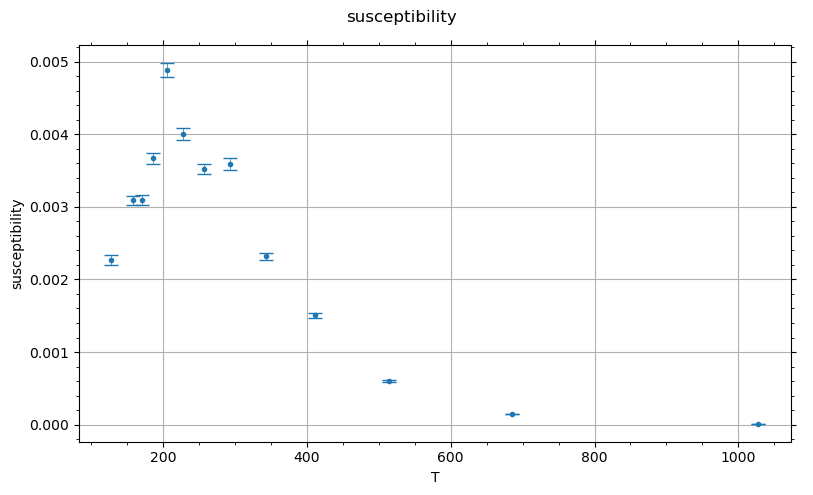

/tmp/ipykernel_979/2609634035.py:57: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df[x_col], df[y_col], p0=p0)


    sample  transition      sigma
0        0  208.593100  29.781848
0        1  209.000723  29.615782
0        2  209.009063  31.602974
0        3  208.588307  29.600727
0        4  209.861815  29.916505
..     ...         ...        ...
0     4995  210.720246  28.516251
0     4996  209.967507  30.396431
0     4997  209.078547  28.058387
0     4998  209.421188  29.205514
0     4999  209.864608  28.890077

[5000 rows x 3 columns]
[2.09458337e+02 4.93212657e-03 2.94001658e+01]


/tmp/ipykernel_979/3519954824.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df1['T'], df1['susceptibility'], p0=p0)


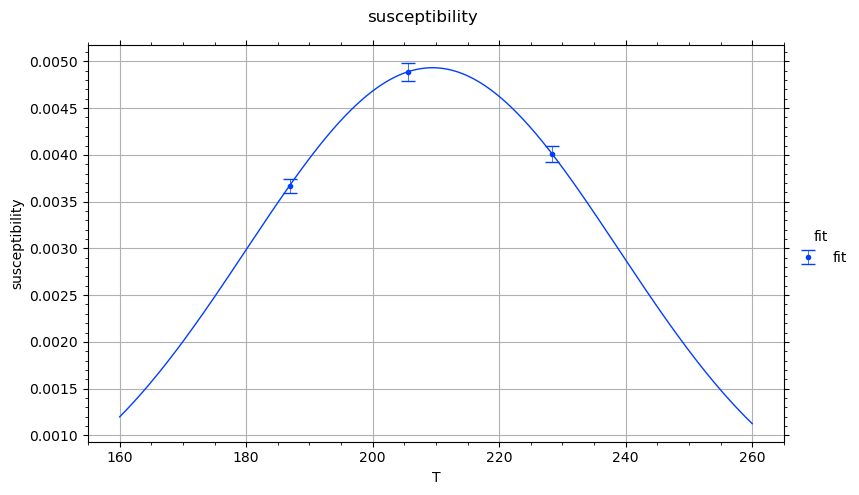

209.47276763710244 0.631575356624214


In [6]:
df_s_0_3p = transition_susceptibility(0, 10, (180, 240), [220, 2, 20])

[ 128.46809896  158.11458333  171.29079861  186.86268939  205.54895833
  228.38773148  256.93619792  293.64136905  342.58159722  411.09791667
  513.87239583  685.16319444 1027.74479167]
[186.86268939 205.54895833 228.38773148 256.93619792]


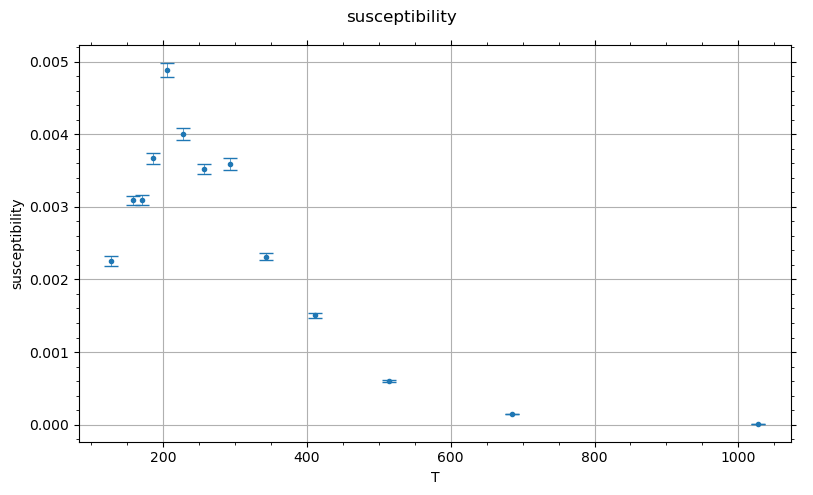

    sample  transition      sigma
0        0  217.334509  50.925562
0        1  216.762041  53.684219
0        2  216.847421  53.702090
0        3  217.337018  58.798924
0        4  217.535986  51.953730
..     ...         ...        ...
0     4995  217.933205  53.767322
0     4996  214.230882  55.473287
0     4997  216.927723  52.986475
0     4998  217.340401  56.891275
0     4999  215.927503  52.964351

[5000 rows x 3 columns]
[2.16228944e+02 4.50464047e-03 5.40703449e+01]


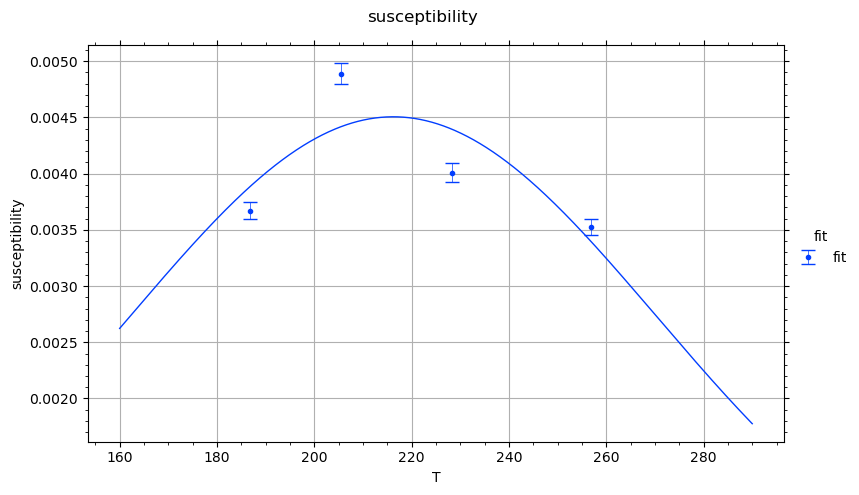

216.17666677528982 1.2614696637007432


In [7]:
df_s_0_4p = transition_susceptibility(0, 10, (180, 270), [220, 2, 20])

[171.29079861 186.86268939 205.54895833 228.38773148 256.93619792
 293.64136905 342.58159722 411.09791667]
[205.54895833 228.38773148 256.93619792]


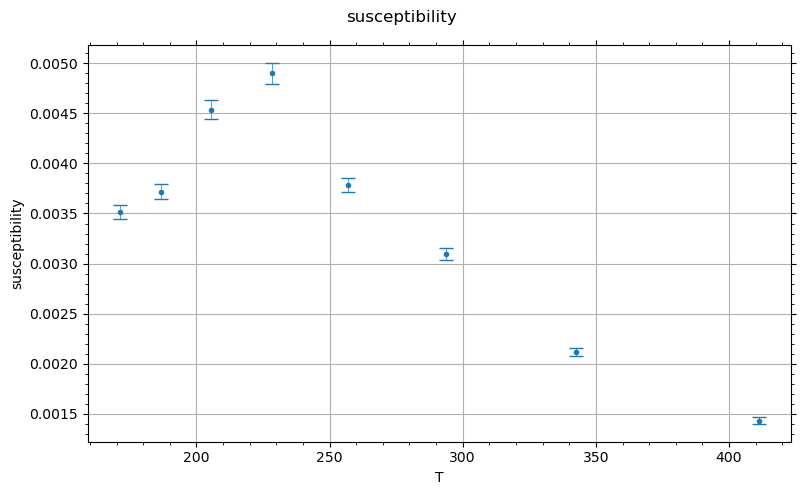

/tmp/ipykernel_979/2609634035.py:57: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df[x_col], df[y_col], p0=p0)


    sample  transition      sigma
0        0  222.594486  48.848648
0        1  225.027309  43.254793
0        2  222.110007  49.423058
0        3  226.487587  40.757697
0        4  226.032675  41.262347
..     ...         ...        ...
0     4995  224.551063  40.390682
0     4996  220.243916  53.817372
0     4997  221.064881  48.833411
0     4998  224.883060  45.163499
0     4999  217.811748  60.413870

[5000 rows x 3 columns]
[2.23973179e+02 4.92352927e-03 4.54451494e+01]


/tmp/ipykernel_979/3519954824.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df1['T'], df1['susceptibility'], p0=p0)


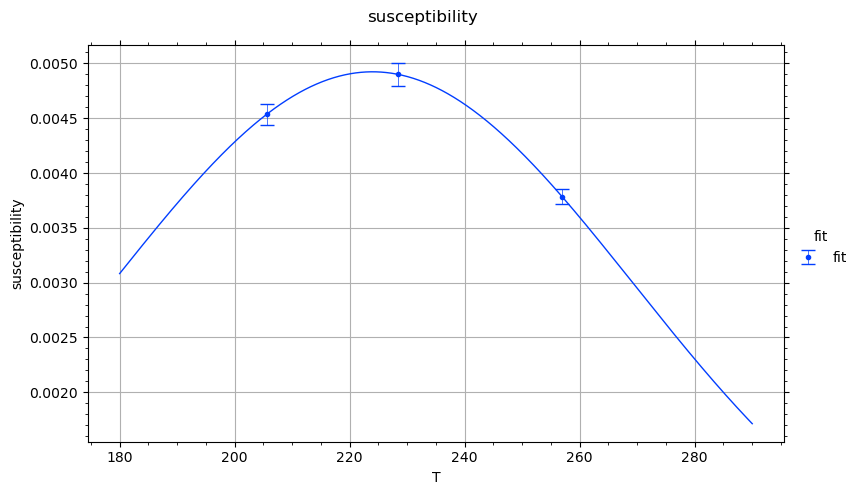

223.74459404470028 1.88598929325352


In [8]:
df_s_0p05_3p = transition_susceptibility(0.05, 10, (200, 270), [220, 2, 20])

[171.29079861 186.86268939 205.54895833 228.38773148 256.93619792
 293.64136905 342.58159722 411.09791667]
[186.86268939 205.54895833 228.38773148 256.93619792]


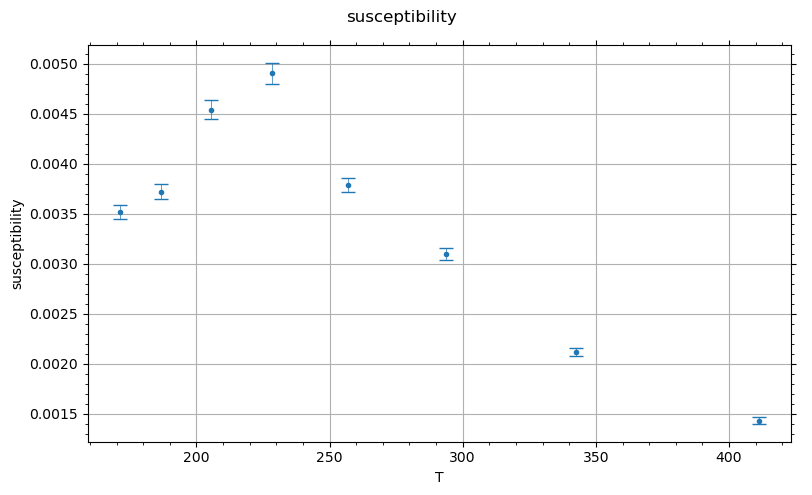

    sample  transition      sigma
0        0  221.149174  47.822008
0        1  224.933926  49.607521
0        2  223.128545  46.679664
0        3  223.550886  48.177054
0        4  221.761888  45.942400
..     ...         ...        ...
0     4995  222.155001  44.363919
0     4996  222.516787  46.808246
0     4997  221.670413  48.219260
0     4998  221.830576  48.194283
0     4999  223.566511  49.869548

[5000 rows x 3 columns]
[2.22832925e+02 4.89620063e-03 4.78998454e+01]


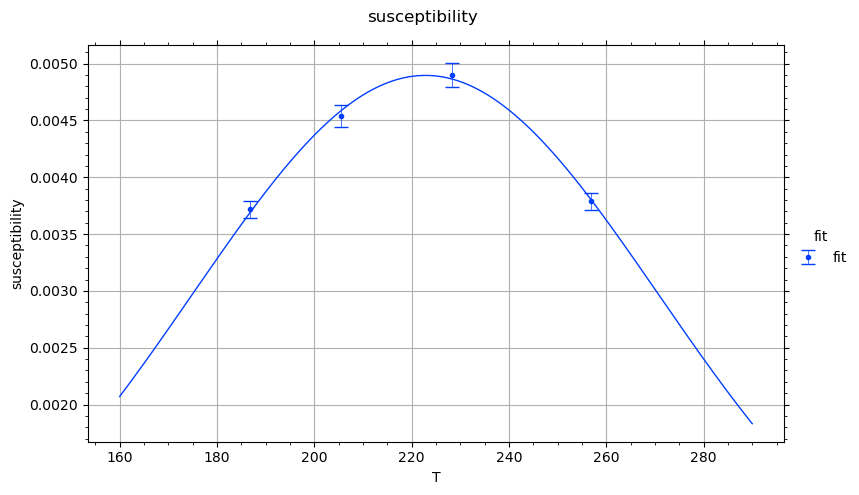

222.83254981444375 0.8848537453838295


In [9]:
df_s_0p05_4p = transition_susceptibility(0.05, 10, (180, 270), [220, 2, 20])

[ 64.23404948 171.29079861 186.86268939 205.54895833 228.38773148
 256.93619792 293.64136905 342.58159722 411.09791667]
[186.86268939 205.54895833 228.38773148]


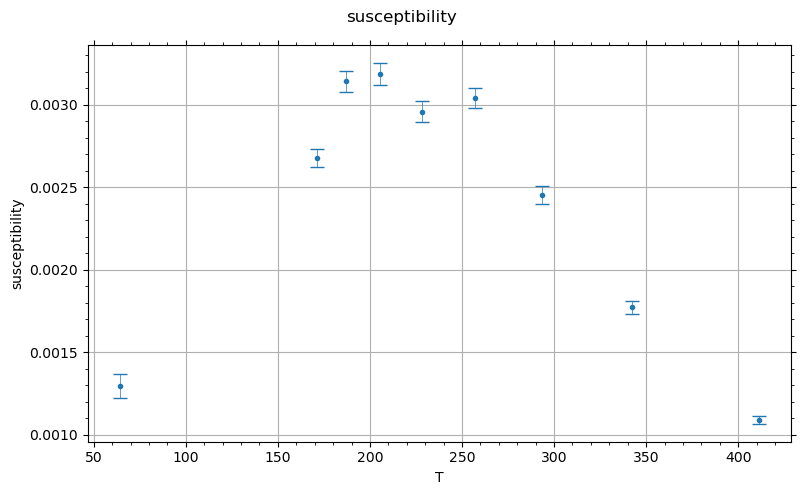

/tmp/ipykernel_979/2609634035.py:57: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df[x_col], df[y_col], p0=p0)


    sample  transition       sigma
0        1  199.015699   74.967014
0        2  121.242539  312.000679
0        3  199.455496   57.030118
0        4  202.859900   61.456506
0        5  197.651951   77.270802
..     ...         ...         ...
0     4995  198.702262   85.411242
0     4996  201.369649   67.811556
0     4997  181.322498  115.515746
0     4998  196.383044   68.131139
0     4999  187.675316  113.673984

[4723 rows x 3 columns]
[2.00166768e+02 3.19726733e-03 7.17050170e+01]


/tmp/ipykernel_979/3519954824.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df1['T'], df1['susceptibility'], p0=p0)


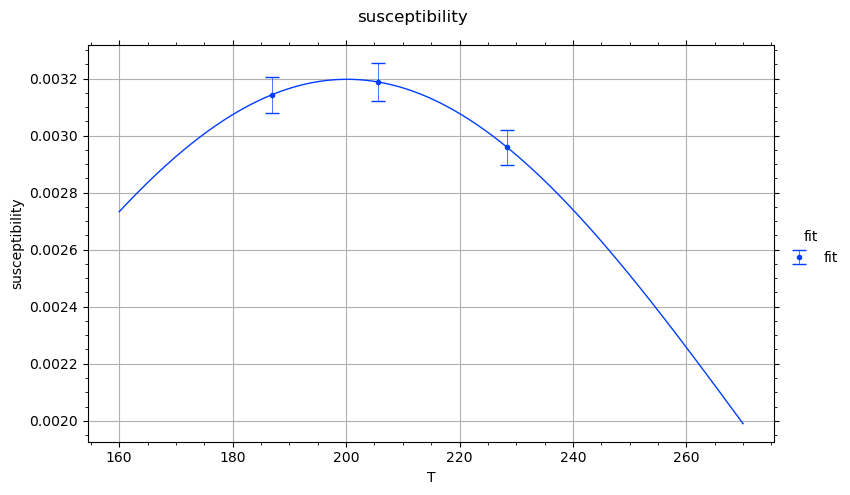

193.75093693148972 50.527452767925965


In [10]:
df_s_0p1_3p = transition_susceptibility(0.1, 10, (180, 250), [220, 2, 20])

[ 64.23404948 171.29079861 186.86268939 205.54895833 228.38773148
 256.93619792 293.64136905 342.58159722 411.09791667]
[171.29079861 186.86268939 205.54895833 228.38773148]


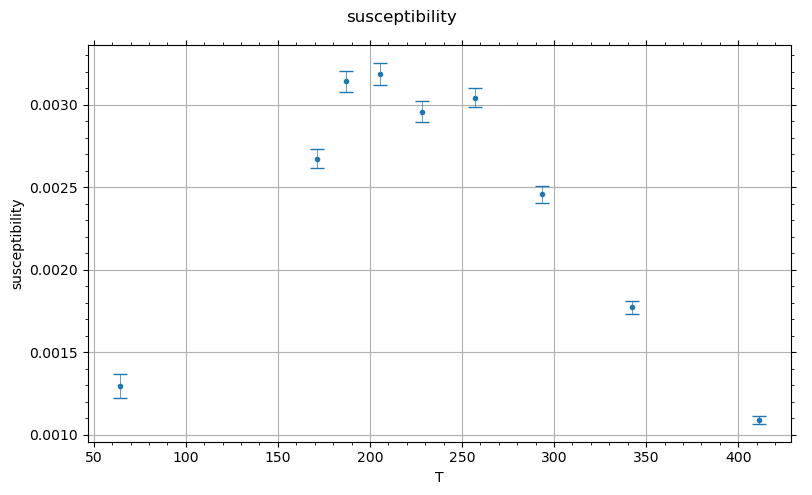

    sample  transition      sigma
0        0  205.532157  60.937945
0        1  205.943398  65.410933
0        2  203.963124  56.855931
0        3  201.212848  56.092996
0        4  205.758090  55.806481
..     ...         ...        ...
0     4995  204.341367  59.159659
0     4996  203.294202  58.462309
0     4997  202.717299  49.975750
0     4998  203.735590  58.844068
0     4999  204.650574  53.825804

[5000 rows x 3 columns]
[2.04354575e+02 3.23888140e-03 5.50090579e+01]


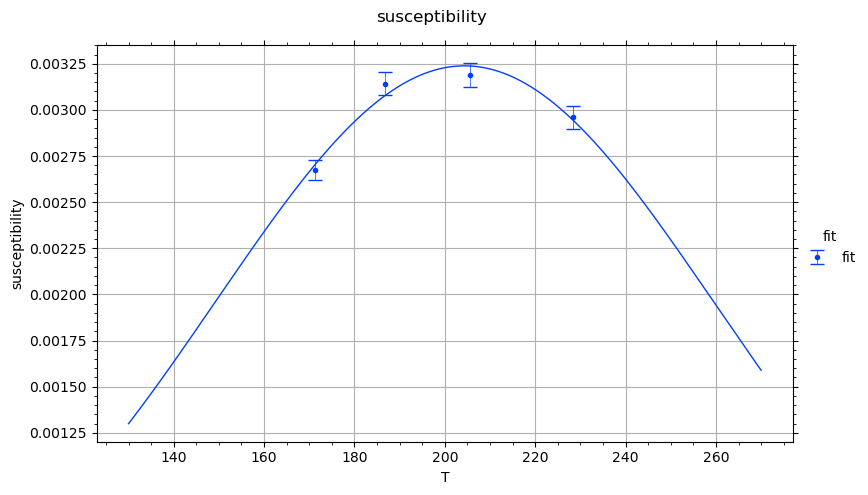

204.49148452758868 1.779564311557519


In [11]:
df_s_0p1_4p = transition_susceptibility(0.1, 10, (150, 250), [220, 2, 20])

[102.77447917 114.19386574 128.46809896 146.82068452 171.29079861
 186.86268939 205.54895833 228.38773148 256.93619792 293.64136905
 342.58159722 411.09791667 513.87239583]
[128.46809896 146.82068452 171.29079861]


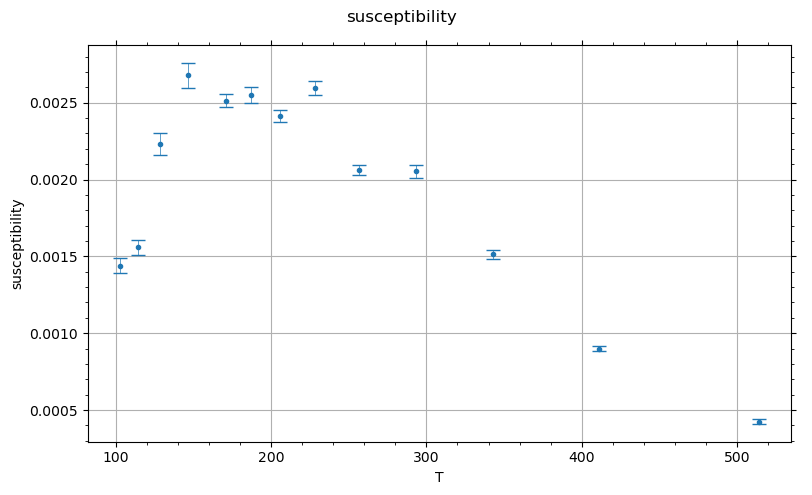

Empty DataFrame
Columns: [sample, transition, sigma]
Index: []


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [19]:
df_s_0p15_3p = transition_susceptibility(0.15, 10, (120, 175), [220, 2, 20])

[102.77447917 114.19386574 128.46809896 146.82068452 171.29079861
 186.86268939 205.54895833 228.38773148 256.93619792 293.64136905
 342.58159722 411.09791667 513.87239583]
[146.82068452 171.29079861 186.86268939 205.54895833]


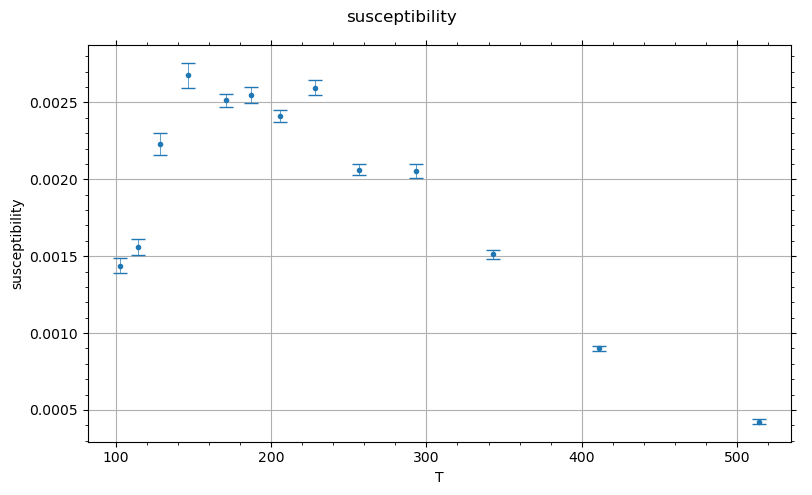

    sample  transition       sigma
0        0  160.832835  112.077638
0        1  137.822578  171.015679
0        3  167.289321  131.205804
0        4  161.899762  121.307350
0        6   82.695694  325.680796
..     ...         ...         ...
0     4994  163.457264  157.261037
0     4995   67.858117  262.549391
0     4997  171.552369   74.811670
0     4998  163.783927  117.383954
0     4999  140.189198  169.665590

[2323 rows x 3 columns]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [148]:
df_s_0p15_4p = transition_susceptibility(0.15, 10, (140, 220), [220, 2, 20])

[102.77447917 114.19386574 128.46809896 146.82068452 171.29079861
 186.86268939 205.54895833 228.38773148 256.93619792 293.64136905
 342.58159722 411.09791667]
[114.19386574 128.46809896 146.82068452]


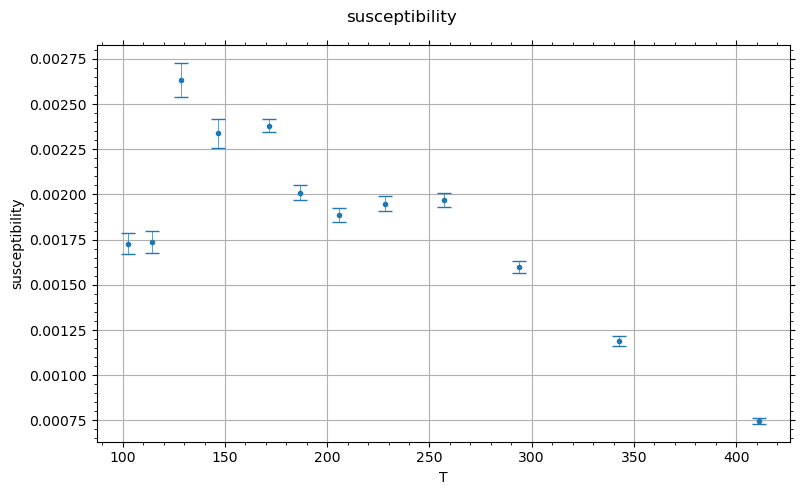

/tmp/ipykernel_979/2609634035.py:57: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df[x_col], df[y_col], p0=p0)


    sample  transition      sigma
0        0  133.227611  20.676593
0        1  136.006038  23.094411
0        2  134.890016  19.475985
0        3  133.359742  19.246935
0        4  134.581530  19.666784
..     ...         ...        ...
0     4995  134.286339  20.325750
0     4996  134.702608  21.619578
0     4997  134.293379  21.386625
0     4998  135.132634  22.896107
0     4999  135.325657  22.459050

[5000 rows x 3 columns]
[1.34673728e+02 2.74640218e-03 2.14105039e+01]


/tmp/ipykernel_979/3519954824.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df1['T'], df1['susceptibility'], p0=p0)


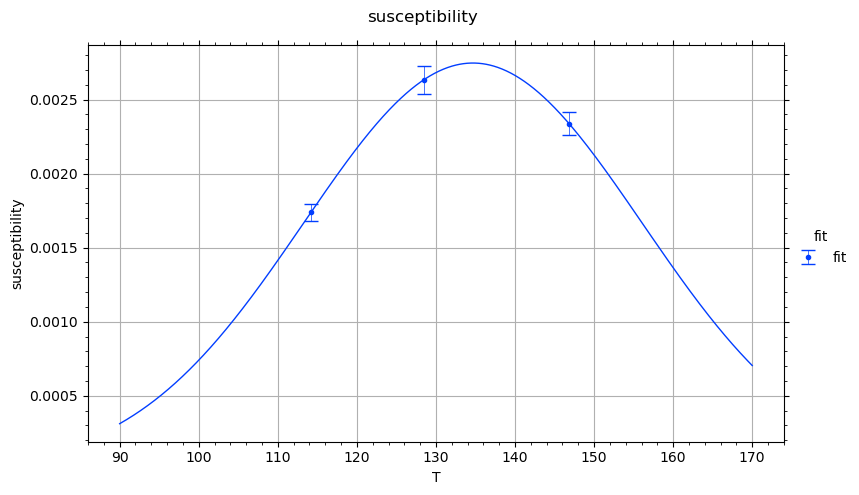

134.77081110521289 0.9653537555005396


In [13]:
df_s_0p2_3p = transition_susceptibility(0.2, 10, (110, 150), [220, 2, 20])

[102.77447917 114.19386574 128.46809896 146.82068452 171.29079861
 186.86268939 205.54895833 228.38773148 256.93619792 293.64136905
 342.58159722 411.09791667]
[102.77447917 114.19386574 128.46809896 146.82068452]


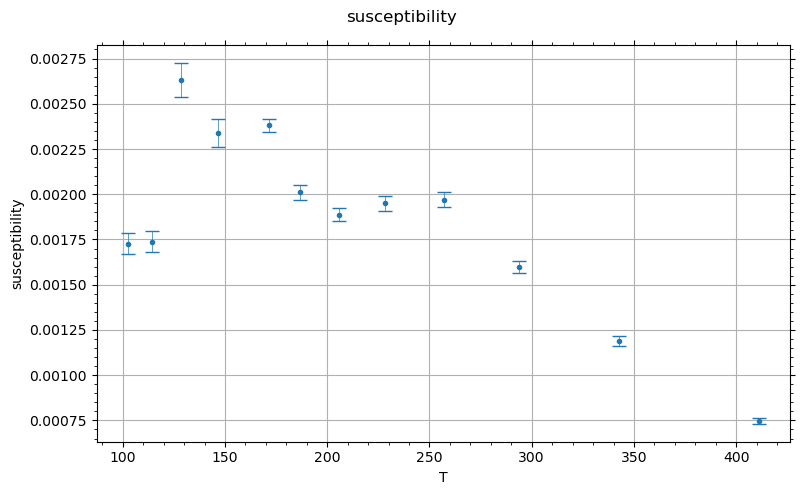

    sample  transition      sigma
0        0  134.742045  33.127437
0        1  138.036080  36.303841
0        2  136.125099  36.373828
0        3  136.488489  35.248395
0        4  134.094151  29.840698
..     ...         ...        ...
0     4995  135.299168  32.771086
0     4996  133.476675  29.077445
0     4997  134.253468  31.971895
0     4998  138.568855  39.957741
0     4999  143.078976  42.690976

[5000 rows x 3 columns]
[1.36489440e+02 2.49760705e-03 3.49301893e+01]


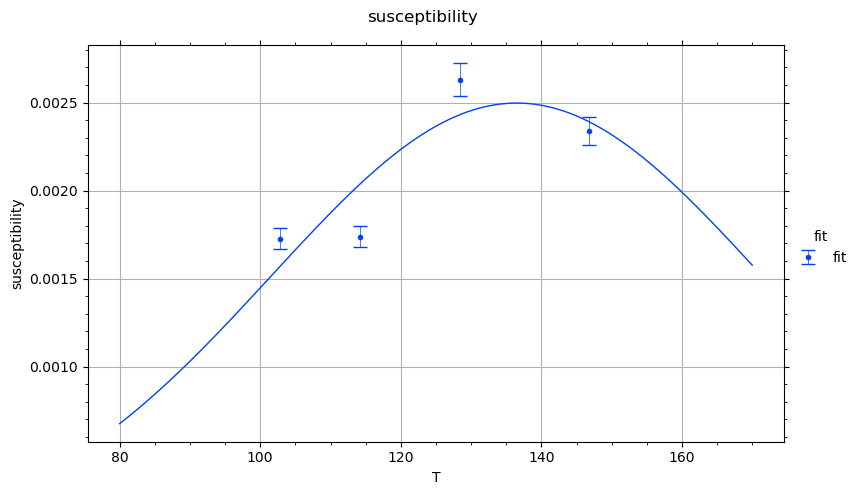

137.13656134336776 3.5931121295832216


In [14]:
df_s_0p2_4p = transition_susceptibility(0.2, 10, (100, 150), [220, 2, 20])

[102.77447917 114.19386574 128.46809896 146.82068452 171.29079861
 186.86268939 205.54895833 228.38773148 256.93619792 293.64136905
 342.58159722 411.09791667]
[114.19386574 128.46809896 146.82068452]


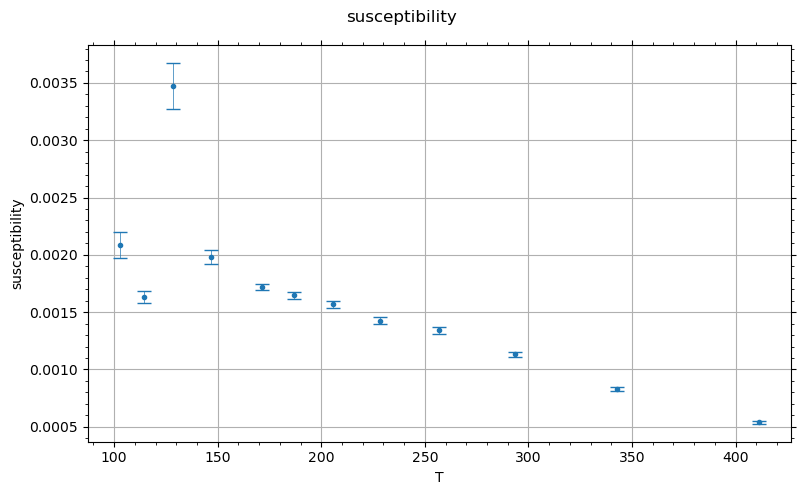

/tmp/ipykernel_979/2609634035.py:57: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df[x_col], df[y_col], p0=p0)


    sample  transition      sigma
0        0  132.023097  14.307689
0        1  131.558579  13.808938
0        2  131.847444  13.479027
0        3  131.540169  13.280208
0        4  131.984248  14.092978
..     ...         ...        ...
0     4995  131.581730  13.592342
0     4996  132.005721  14.928864
0     4997  131.930601  13.784817
0     4998  132.656497  14.958706
0     4999  131.763497  13.507656

[5000 rows x 3 columns]
[1.31666922e+02 3.56295584e-03 1.39859816e+01]


/tmp/ipykernel_979/3519954824.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_gaussian, df1['T'], df1['susceptibility'], p0=p0)


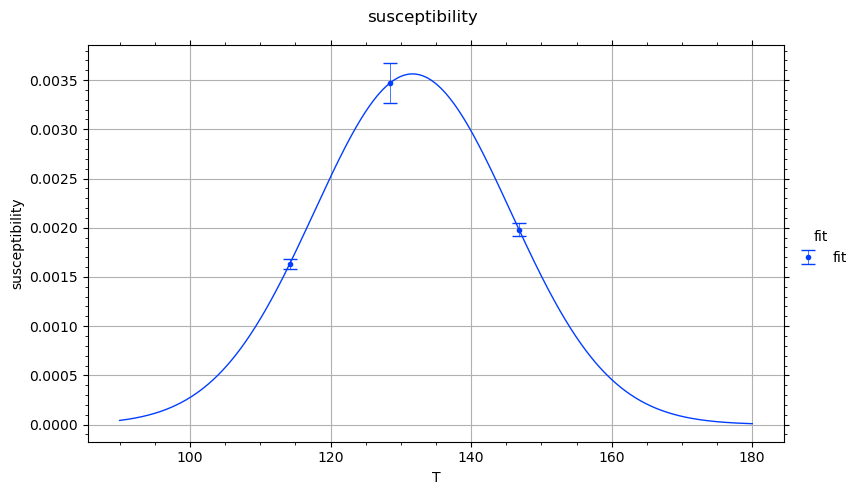

131.67877833894534 0.29222465595416586


In [15]:
df_s_0p25_3p = transition_susceptibility(0.25, 10, (110, 160), [220, 2, 20])

[102.77447917 114.19386574 128.46809896 146.82068452 171.29079861
 186.86268939 205.54895833 228.38773148 256.93619792 293.64136905
 342.58159722 411.09791667]
[114.19386574 128.46809896 146.82068452 171.29079861]


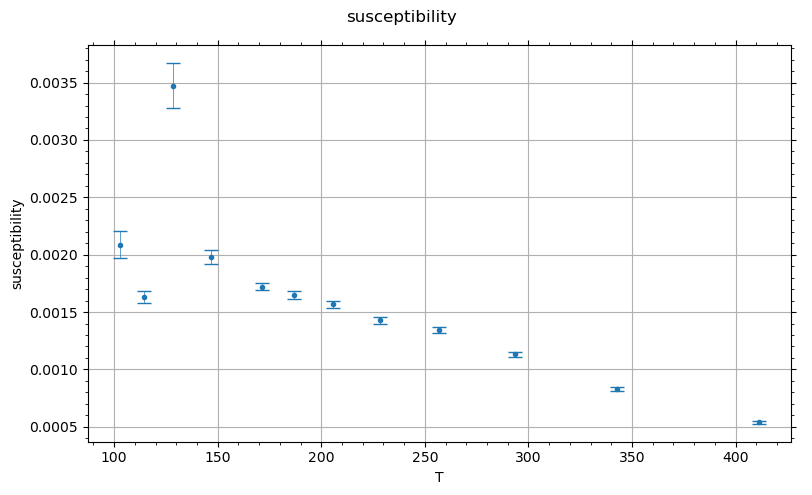

Empty DataFrame
Columns: [sample, transition, sigma]
Index: []


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [16]:
df_s_0p25_4p = transition_susceptibility(0.25, 10, (110, 175), [220, 2, 20])

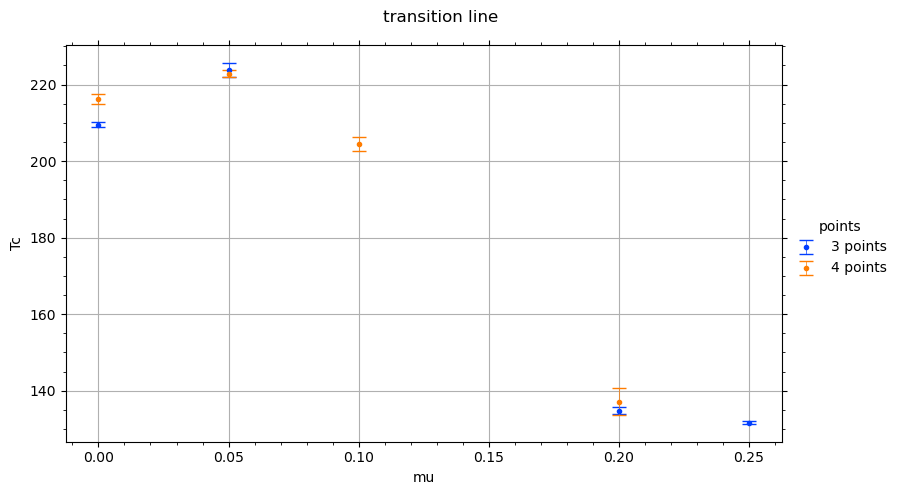

In [20]:
df_transition_line_s_3p = pd.concat([df_s_0_3p, df_s_0p05_3p, df_s_0p2_3p, df_s_0p25_3p])
df_transition_line_s_3p['points'] = '3 points'
df_transition_line_s_4p = pd.concat([df_s_0_4p, df_s_0p05_4p, df_s_0p1_4p, df_s_0p2_4p])
df_transition_line_s_4p['points'] = '4 points'
df_transition_line_s_all = pd.concat([df_transition_line_s_3p, df_transition_line_s_4p])
plots.plot_potential_single(df_transition_line_s_all, 'mu', 'transition', 'points', 'mu', 'Tc', 'transition line', f'../../images/potential/su2/qc2dstag/', 'transition_line', True, err='transition_err')

In [3]:
def transition_polyakov_loops(mu, smapling_func, fit_func, HYP, T_borders, p0):
    df1 = pd.read_csv('/home/ilya/soft/lattice/observables/result/merged/polyakov_loop/polyakov_loops.csv')
    df1['owner'] = 'Ilya'
    df1 = df1[df1['Ns'] == 32]
    df1 = df1[~df1['Nt'].isin([17, 19])]
    # df1 = df1[~((df1['chain'] == 's0') & (df1['conf'] <= 200))]
    df2 = pd.read_csv('/home/ilya/soft/lattice/observables/result/vladimir_data/merged/polyakov_loop/polyakov_loops.csv')
    df2['owner'] = 'Vladimir'
    df = pd.concat([df1, df2], ignore_index=True)
    df = df[df['mu'] == mu]
    df = df[df['HYP'] == HYP]
    fm_to_GeV = 1/0.197327
    a = 0.048 * fm_to_GeV / 1000
    df['T'] = 1 / (df['Nt'] * a)
    df_aver = df.groupby(['T', 'Nt'])['PL']\
                      .agg([('PL', 'mean'), ('err', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index(level=['T', 'Nt'])
    # print(df_aver)
    df['PL'] = df['PL'] * (1.017 ** df['Nt'])
    print(np.sort(df['T'].unique()))
    # print(df)
    df = df.groupby(['T', 'Nt']).apply(polyakov_loops_sample, 5000, include_groups=False).reset_index(level=['T', 'Nt'])
    # print(df)
    df1 = df.groupby(['T'])['PL']\
                      .agg([('PL', 'mean'), ('err', lambda x: np.std(x, ddof=0))]).reset_index(level=['T'])
    df = df[df['T'] > T_borders[0]]
    df = df[df['T'] < T_borders[1]]
    print(np.sort(df['T'].unique()))
    plots.plot_potential_single(df1, 'T', 'PL', None, 'T', 'PL', 'PL', f'../../images/potential/su2/qc2dstag/', 'polyakov loop', True, err='err')
    df_transition = df.groupby(['sample']).apply(smapling_func, 'T', 'PL', include_groups=False).reset_index(level='sample')
    df_transition = df_transition.dropna()
    print(df_transition)
    df1 = df1[df1['T'] > T_borders[0]]
    df1 = df1[df1['T'] < T_borders[1]]
    popt, pcov = scipy.optimize.curve_fit(fit_func, df1['T'], df1['PL'], p0=p0)
    print(popt)
    x_fit = np.linspace(T_borders[0] - 20, T_borders[1] + 20, 1000)
    y_fit = fit_func(x_fit, *popt)
    df_fit = pd.DataFrame({'T': x_fit, 'PL': y_fit})
    df_fit['fit'] = 'fit'
    df1['fit'] = 'fit'
    # print(df)
    plots.plot_potential_single(df1, 'T', 'PL', 'fit', 'T', 'PL', 'PL', f'../../images/potential/su2/qc2dstag/', 'polyakov loop', True, err='err', df_fits=df_fit)
    print(df_transition['transition'].mean(), df_transition['transition'].std(ddof=0))
    return pd.DataFrame({'mu': [mu], 'transition': [df_transition['transition'].mean()], 'transition_err': [df_transition['transition'].std(ddof=0)]})

[ 128.46809896  158.11458333  171.29079861  186.86268939  205.54895833
  228.38773148  256.93619792  293.64136905  342.58159722  411.09791667
  513.87239583  685.16319444 1027.74479167]
[186.86268939 205.54895833 228.38773148 256.93619792]


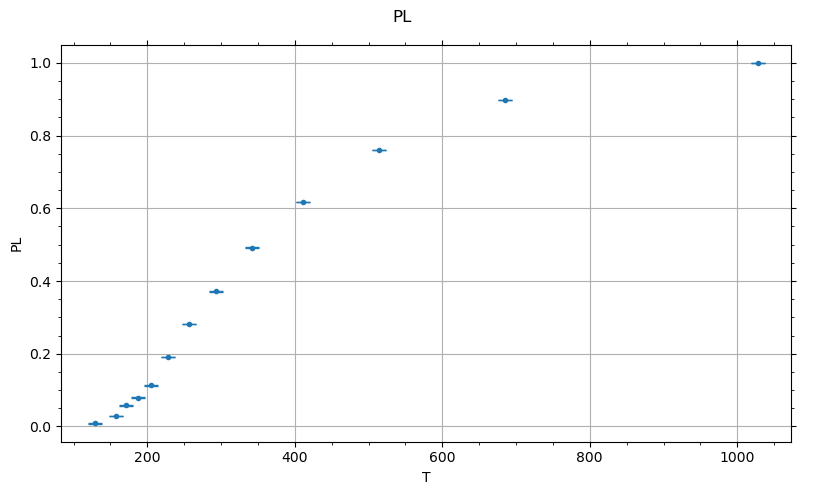

/tmp/ipykernel_891/2609634035.py:69: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_polinom_3, df[x_col], df[y_col])


    sample  transition
0        0  227.502414
0        1  228.028598
0        2  228.095600
0        3  226.733069
0        4  225.970302
..     ...         ...
0     4995  228.400235
0     4996  228.302229
0     4997  226.822258
0     4998  227.145106
0     4999  226.273004

[5000 rows x 2 columns]
[-6.26638950e-07  4.27884078e-04 -9.36775025e-02  6.73224010e+00]


/tmp/ipykernel_891/2330529987.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_func, df1['T'], df1['PL'], p0=p0)


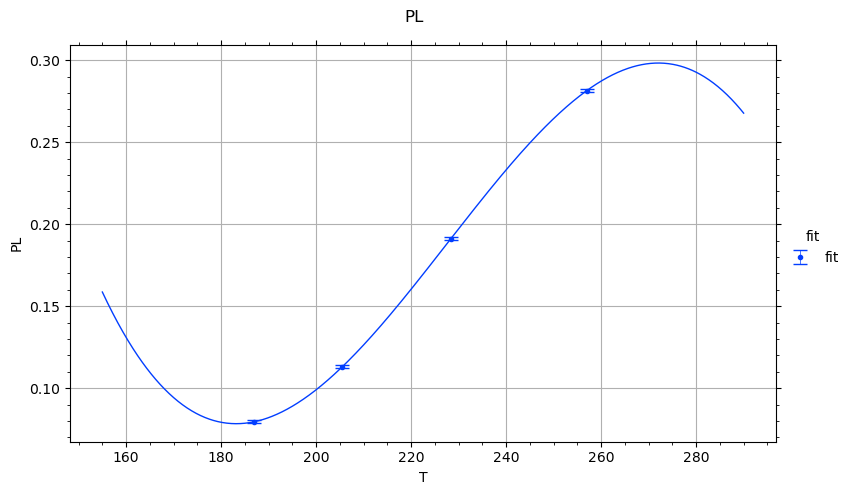

227.66472191050173 0.7435431853570271


In [4]:
df_p_0 = transition_polyakov_loops(0, fit_samples_3, fit_polinom_3, 10, [175, 270], None)

[171.29079861 186.86268939 205.54895833 228.38773148 256.93619792
 293.64136905 342.58159722 411.09791667]
[186.86268939 205.54895833 228.38773148 256.93619792]


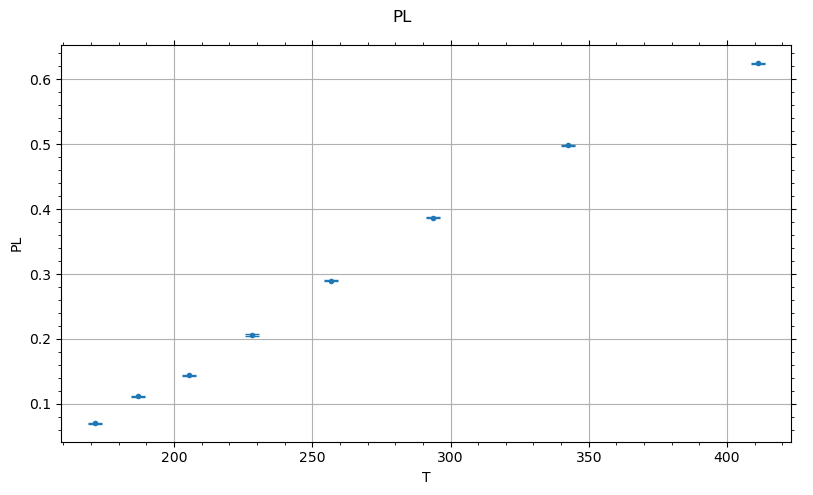

/tmp/ipykernel_891/2609634035.py:69: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_polinom_3, df[x_col], df[y_col])


    sample  transition
0        0  233.804594
0        1  231.139401
0        2  235.009762
0        3  230.833991
0        4  237.669931
..     ...         ...
0     4995  232.926570
0     4996  233.874423
0     4997  234.467091
0     4998  239.803937
0     4999  237.714801

[5000 rows x 2 columns]
[-2.91300328e-07  2.04968890e-04 -4.50314930e-02  3.26976474e+00]


/tmp/ipykernel_891/2330529987.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_func, df1['T'], df1['PL'], p0=p0)


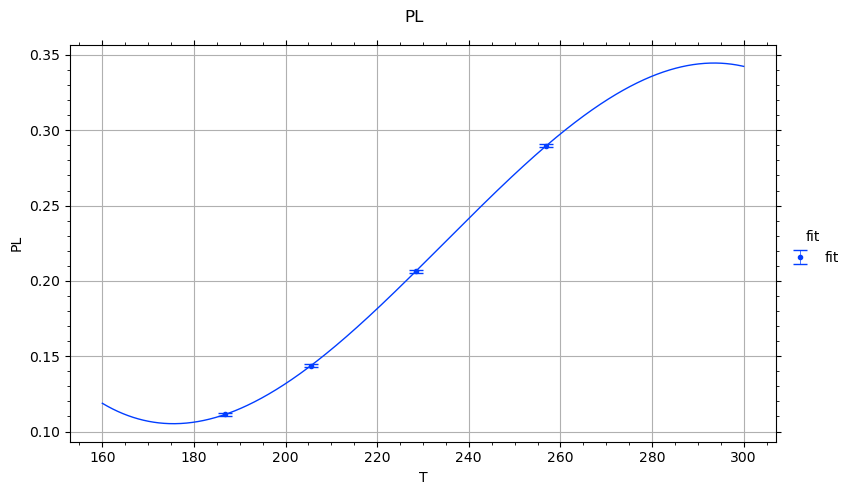

235.21330158922729 3.624225189461662


In [5]:
df_p_0p05 = transition_polyakov_loops(0.05, fit_samples_3, fit_polinom_3, 10, [180, 280], None)

[ 64.23404948 171.29079861 186.86268939 205.54895833 228.38773148
 256.93619792 293.64136905 342.58159722 411.09791667]
[171.29079861 186.86268939 205.54895833 228.38773148 256.93619792]


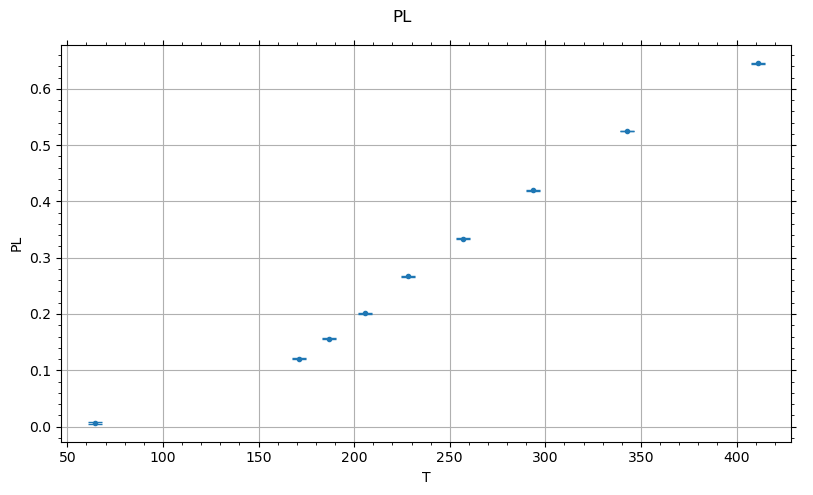

    sample  transition
0        0  215.803431
0        1  215.639604
0        2  213.805715
0        3  213.788769
0        4  213.605939
..     ...         ...
0     4995  215.599281
0     4996  215.007504
0     4997  213.550031
0     4998  215.791309
0     4999  213.344419

[5000 rows x 2 columns]
[-1.55858250e-07  1.00354194e-04 -1.87696316e-02  1.17475260e+00]


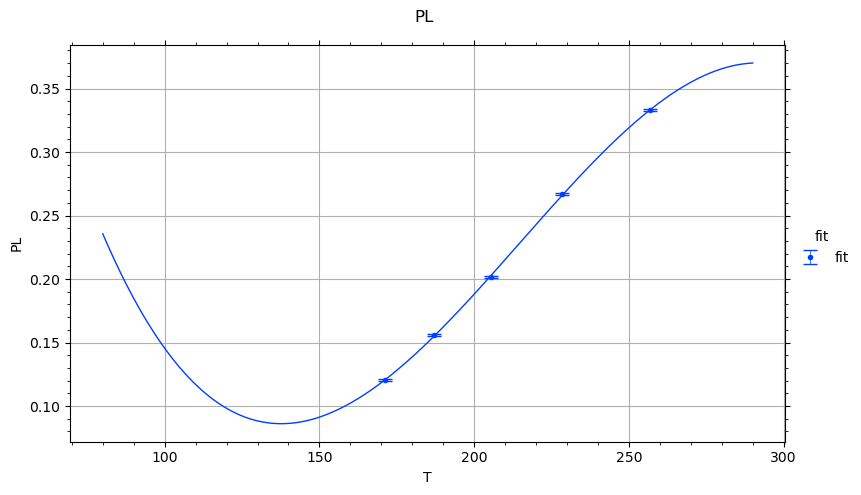

214.64116629768702 1.0116983354548978


In [6]:
df_p_0p1 = transition_polyakov_loops(0.1, fit_samples_3, fit_polinom_3, 10, [100, 270], None)

[102.77447917 114.19386574 128.46809896 146.82068452 171.29079861
 186.86268939 205.54895833 228.38773148 256.93619792 293.64136905
 342.58159722 411.09791667 513.87239583]
[114.19386574 128.46809896 146.82068452 171.29079861 186.86268939]


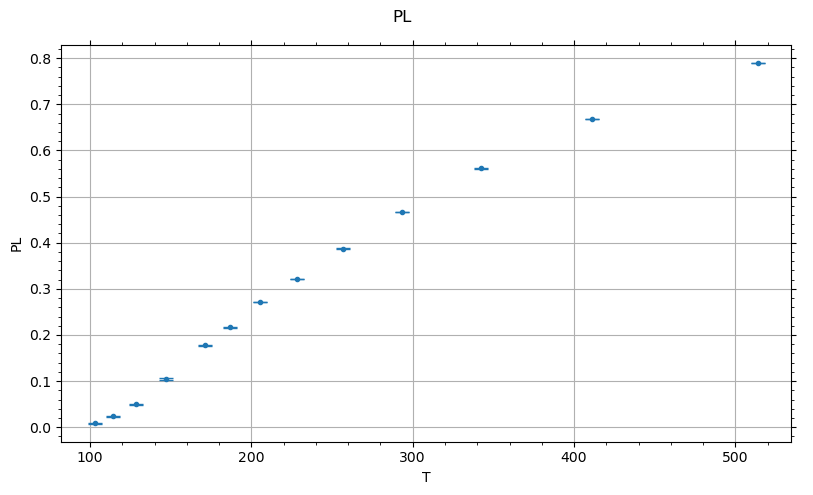

    sample  transition
0        0  154.587611
0        1  153.961799
0        2  153.412715
0        3  152.409550
0        4  153.550220
..     ...         ...
0     4995  153.024043
0     4996  153.553386
0     4997  153.080377
0     4998  153.465960
0     4999  152.561065

[5000 rows x 2 columns]
[-3.66255802e-07  1.68831295e-04 -2.27929114e-02  9.69733775e-01]


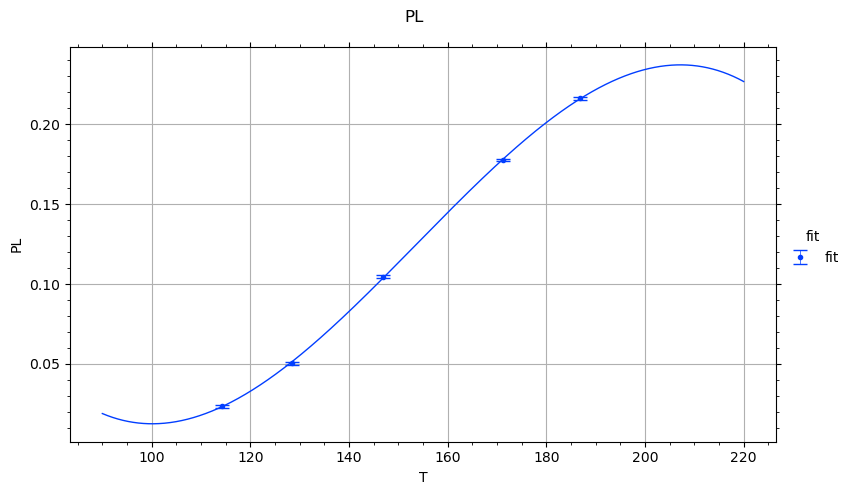

153.67411731488812 0.7514343083526435


In [7]:
df_p_0p15 = transition_polyakov_loops(0.15, fit_samples_3, fit_polinom_3, 10, [110, 200], None)

[102.77447917 114.19386574 128.46809896 146.82068452 171.29079861
 186.86268939 205.54895833 228.38773148 256.93619792 293.64136905
 342.58159722 411.09791667]
[114.19386574 128.46809896 146.82068452 171.29079861]


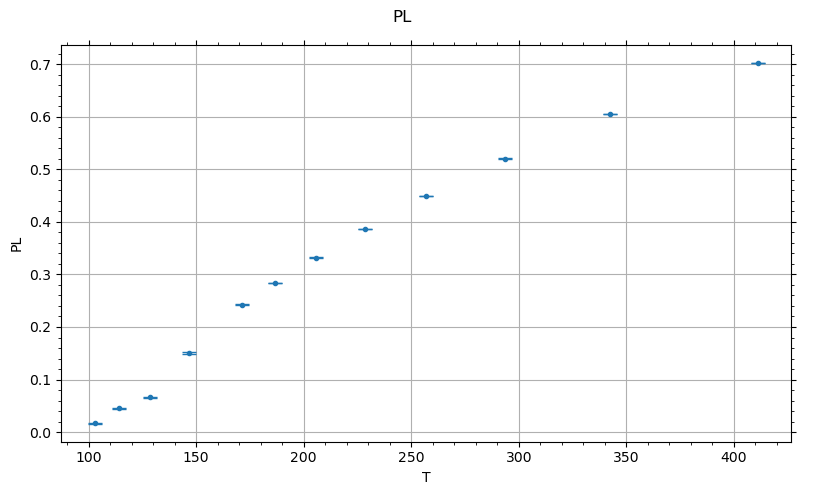

/tmp/ipykernel_891/2609634035.py:69: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_polinom_3, df[x_col], df[y_col])


    sample  transition
0        0  145.758091
0        1  146.179948
0        2  145.814394
0        3  144.991673
0        4  145.464569
..     ...         ...
0     4995  145.590499
0     4996  145.737532
0     4997  145.639651
0     4998  145.597475
0     4999  145.505006

[5000 rows x 2 columns]
[-2.02953570e-06  8.86890389e-04 -1.24029705e-01  5.66583783e+00]


/tmp/ipykernel_891/2330529987.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_func, df1['T'], df1['PL'], p0=p0)


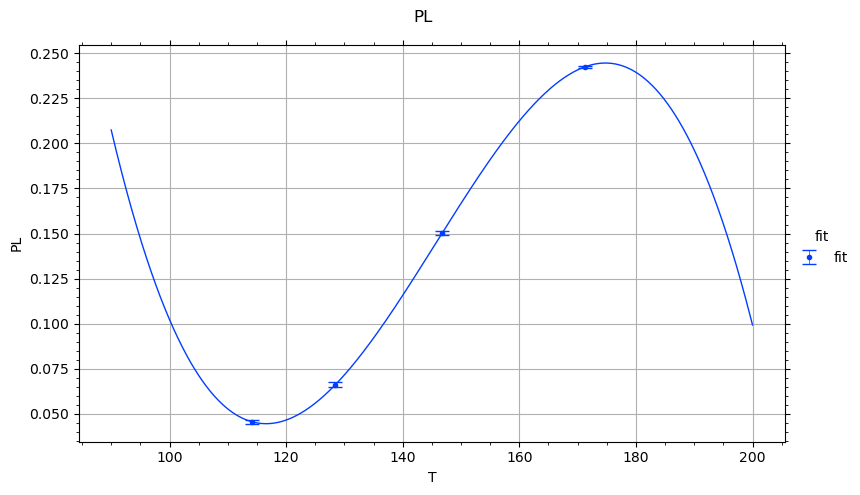

145.6788053895834 0.32006129279420387


In [8]:
df_p_0p2 = transition_polyakov_loops(0.2, fit_samples_3, fit_polinom_3, 10, [110, 180], None)

[102.77447917 114.19386574 128.46809896 146.82068452 171.29079861
 186.86268939 205.54895833 228.38773148 256.93619792 293.64136905
 342.58159722 411.09791667]
[114.19386574 128.46809896 146.82068452 171.29079861]


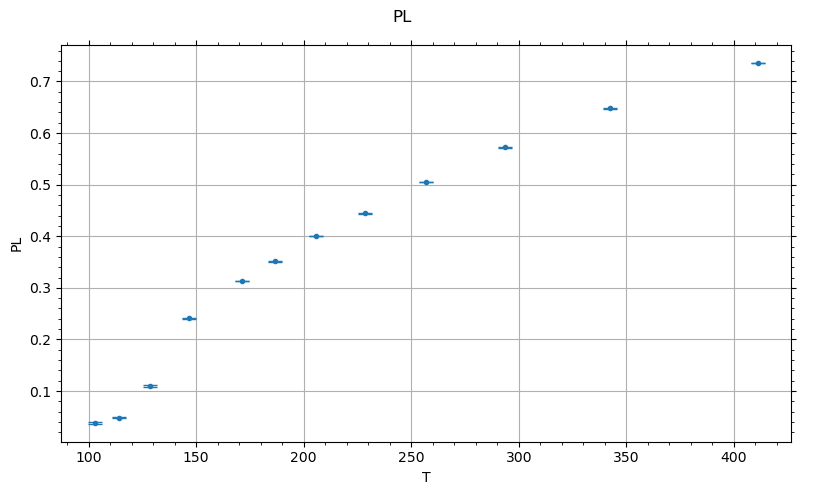

/tmp/ipykernel_891/2609634035.py:69: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_polinom_3, df[x_col], df[y_col])


    sample  transition
0        0  138.916941
0        1  138.994086
0        2  138.653757
0        3  138.418786
0        4  139.167152
..     ...         ...
0     4995  138.320121
0     4996  138.335685
0     4997  139.323194
0     4998  138.920653
0     4999  139.136917

[5000 rows x 2 columns]
[-3.32524466e-06  1.38545979e-03 -1.84931221e-01  8.05163608e+00]


/tmp/ipykernel_891/2330529987.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(fit_func, df1['T'], df1['PL'], p0=p0)


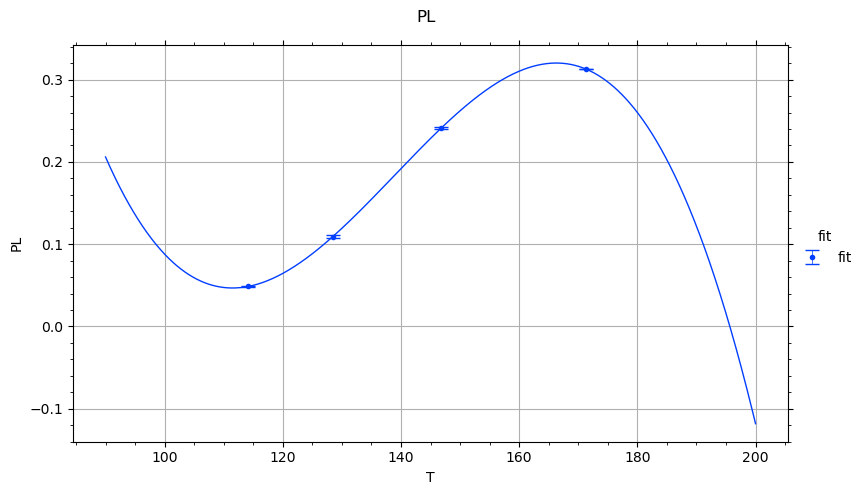

138.86605535917226 0.3127011517762641


In [9]:
df_p_0p25 = transition_polyakov_loops(0.25, fit_samples_3, fit_polinom_3, 10, [110, 180], None)

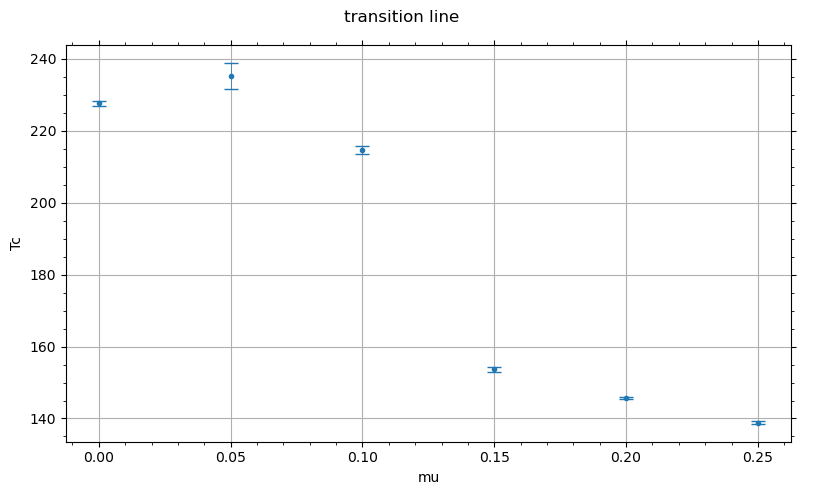

In [12]:
df_transition_line_p = pd.concat([df_p_0, df_p_0p05, df_p_0p1, df_p_0p15, df_p_0p2, df_p_0p25])
df_transition_line_p.to_csv(f"../../result/polyakov_loop/su2/qc2dstag/transition_line_inflection_point.csv", index=False)
plots.plot_potential_single(df_transition_line_p, 'mu', 'transition', None, 'mu', 'Tc', 'transition line', f'../../images/potential/su2/qc2dstag/', 'transition_line', True, err='transition_err')

               PL  HYP  conf  Nt  Ns   mu chain           T
72665    0.078937   10     0  22  32  0.0    s3  186.862689
72676    0.070255   10     1  22  32  0.0    s3  186.862689
72687    0.093750   10     2  22  32  0.0    s3  186.862689
72698    0.093207   10     3  22  32  0.0    s3  186.862689
72709    0.125522   10     4  22  32  0.0    s3  186.862689
...           ...  ...   ...  ..  ..  ...   ...         ...
3089096  0.348113   10   996  14  32  0.0    s2  293.641369
3089107  0.328198   10   997  14  32  0.0    s2  293.641369
3089118  0.277421   10   998  14  32  0.0    s2  293.641369
3089129  0.274665   10   999  14  32  0.0    s2  293.641369
3089140  0.272239   10  1000  14  32  0.0    s2  293.641369

[33025 rows x 8 columns]
   HYP           T  Nt  Ns   mu        PL       err
0   10  171.290799  24  32  0.0  0.058028  0.000821
1   10  186.862689  22  32  0.0  0.079420  0.000893
2   10  205.548958  20  32  0.0  0.113135  0.001031
3   10  228.387731  18  32  0.0  0.191183  0.0

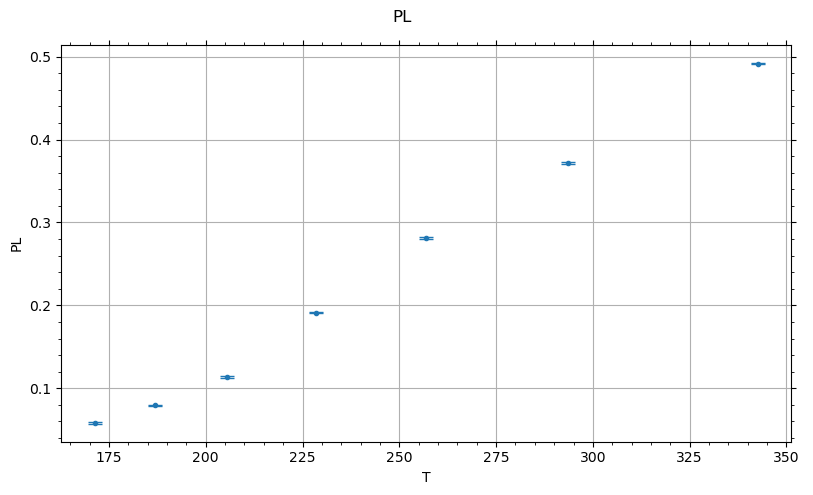

In [109]:
df = pd.read_csv('/home/ilya/soft/lattice/observables/result/vladimir_data/merged/polyakov_loop/polyakov_loops.csv')
df = df[df['mu'] == 0]
df = df[df['HYP'] == 10]
fm_to_GeV = 1/0.197327
a = 0.048 * fm_to_GeV / 1000
df['T'] = 1 / (df['Nt'] * a)
df = df[df['T'] > 160]
df = df[df['T'] < 350]
print(df)
df = df.groupby(['HYP', 'T', 'Nt', 'Ns', 'mu'])['PL']\
                  .agg([('PL', 'mean'), ('err', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index(level=['HYP', 'T', 'Nt', 'Ns', 'mu'])
df['PL'] = df['PL'] * 1.017**df['Nt']
df['err'] = df['err'] * 1.017**df['Nt']
print(df)
plots.plot_potential_single(df, 'T', 'PL', None, 'T', 'PL', 'PL', f'../../images/potential/su2/qc2dstag/', 'polyakov loop', True, err='err')

    HYP_step  polyakov_loop  polyakov_loop_err  susceptibility  \
10        10       0.689409           0.000404        0.000324   
10        10       0.295426           0.000785        0.001200   
10        10       0.232763           0.000890        0.001570   
10        10       0.192926           0.000833        0.001354   
10        10       0.122069           0.000717        0.001001   
10        10       0.065271           0.000731        0.001042   
10        10       0.029377           0.000624        0.000758   
10        10       0.012809           0.000488        0.000464   
10        10       0.004411           0.000468        0.000374   

    susceptibility_err  Nt           T  
10            0.000011   8  560.588068  
10            0.000036  16  280.294034  
10            0.000063  18  249.150253  
10            0.000042  20  224.235227  
10            0.000031  24  186.862689  
10            0.000031  28  160.168019  
10            0.000024  32  140.147017  
10         

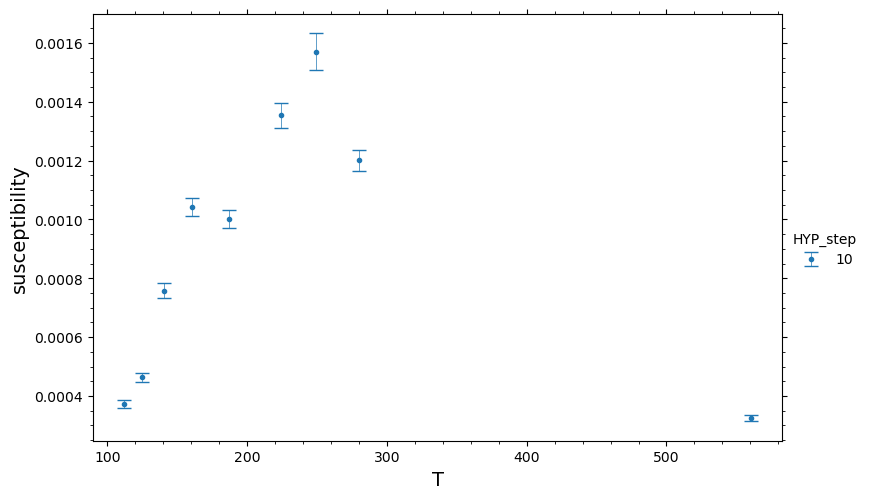

In [ ]:
fm_to_GeV = 1/0.197327
a = 0.048 * fm_to_GeV / 1000
df = []
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x8/mu0.15/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 8
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x16/mu0.15/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 16
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x18/mu0.15/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 18
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x20/mu0.15/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 20
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x24/mu0.15/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 24
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x28/mu0.15/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 28
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x32/mu0.15/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 32
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x36/mu0.15/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 36
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x40/mu0.15/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 40
df = pd.concat(df)
df = df[df['HYP_step'] == 10]
df['T'] = 1 / a / df['Nt']
print(df)
fg = seaborn.FacetGrid(data=df, hue='HYP_step', height=5,
                           aspect=1.6, legend_out=True)
fg.map(plt.errorbar, 'T', 'susceptibility', 'susceptibility_err', mfc=None, fmt='o', ms=3, capsize=5, lw=0.5, ls=None
           ).add_legend()
fg.ax.set_xlabel('T', fontsize=14)
fg.ax.set_ylabel('susceptibility', fontsize=14)
fg.ax.spines['right'].set_visible(True)
fg.ax.spines['top'].set_visible(True)
fg.ax.minorticks_on()
fg.ax.tick_params(which='both', bottom=True,
                  top=True, left=True, right=True)

    HYP_step  polyakov_loop  polyakov_loop_err  susceptibility  \
10        10       0.160718           0.000521        0.001074   
10        10       0.093874           0.000711        0.000910   
10        10       0.038573           0.000710        0.000895   
10        10       0.024782           0.000515        0.000517   
10        10       0.008678           0.000480        0.000449   

    susceptibility_err  Nt           T  
10            0.000025  24  186.862689  
10            0.000031  28  160.168019  
10            0.000031  32  140.147017  
10            0.000018  36  124.575126  
10            0.000015  40  112.117614  


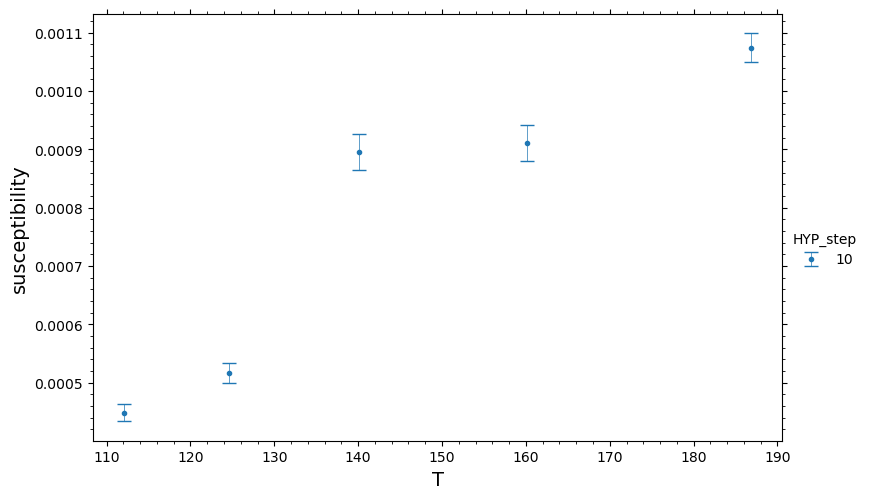

In [ ]:
fm_to_GeV = 1/0.197327
a = 0.044 * fm_to_GeV / 1000
df = []
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x24/mu0.20/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 24
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x28/mu0.20/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 28
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x32/mu0.20/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 32
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x36/mu0.20/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 36
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x40/mu0.20/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 40
df = pd.concat(df)
df = df[df['HYP_step'] == 10]
df['T'] = 1 / a / df['Nt']
print(df)
fg = seaborn.FacetGrid(data=df, hue='HYP_step', height=5,
                           aspect=1.6, legend_out=True)
fg.map(plt.errorbar, 'T', 'susceptibility', 'susceptibility_err', mfc=None, fmt='o', ms=3, capsize=5, lw=0.5, ls=None
           ).add_legend()
fg.ax.set_xlabel('T', fontsize=14)
fg.ax.set_ylabel('susceptibility', fontsize=14)
fg.ax.spines['right'].set_visible(True)
fg.ax.spines['top'].set_visible(True)
fg.ax.minorticks_on()
fg.ax.tick_params(which='both', bottom=True,
                  top=True, left=True, right=True)

    HYP_step  polyakov_loop  polyakov_loop_err  susceptibility  \
10        10       0.206703           0.000629        0.000784   
10        10       0.150452           0.000629        0.000771   
10        10       0.063676           0.001199        0.001182   
10        10       0.026513           0.000519        0.000486   
10        10       0.019283           0.000597        0.000542   

    susceptibility_err  Nt           T  
10            0.000024  24  186.862689  
10            0.000024  28  160.168019  
10            0.000068  32  140.147017  
10            0.000016  36  124.575126  
10            0.000030  40  112.117614  


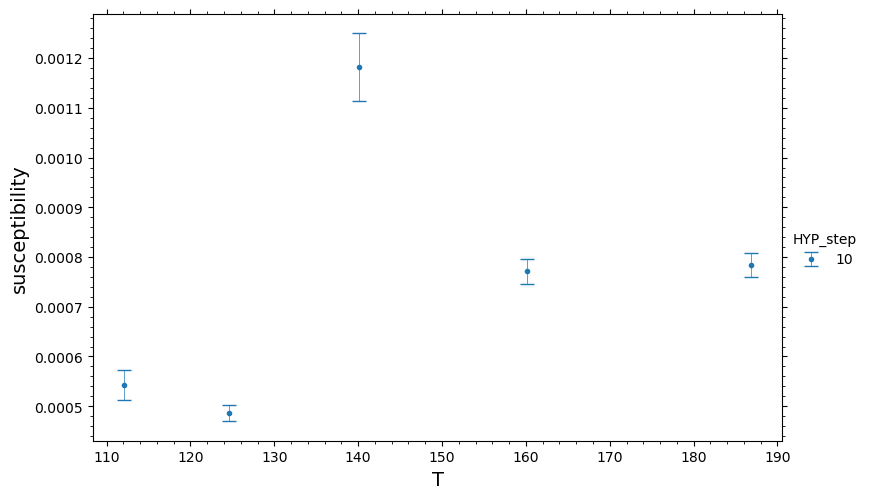

In [ ]:
fm_to_GeV = 1/0.197327
a = 0.044 * fm_to_GeV / 1000
df = []
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x24/mu0.25/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 24
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x28/mu0.25/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 28
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^4/mu0.25/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 32
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x36/mu0.25/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 36
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x40/mu0.25/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['Nt'] = 40
df = pd.concat(df)
df = df[df['HYP_step'] == 10]
df['T'] = 1 / a / df['Nt']
print(df)
fg = seaborn.FacetGrid(data=df, hue='HYP_step', height=5,
                           aspect=1.6, legend_out=True)
fg.map(plt.errorbar, 'T', 'susceptibility', 'susceptibility_err', mfc=None, fmt='o', ms=3, capsize=5, lw=0.5, ls=None
           ).add_legend()
fg.ax.set_xlabel('T', fontsize=14)
fg.ax.set_ylabel('susceptibility', fontsize=14)
fg.ax.spines['right'].set_visible(True)
fg.ax.spines['top'].set_visible(True)
fg.ax.minorticks_on()
fg.ax.tick_params(which='both', bottom=True,
                  top=True, left=True, right=True)

    HYP_step  polyakov_loop  polyakov_loop_err  susceptibility  \
10        10      -0.000279           0.000480        0.000184   
10        10       0.002179           0.000302        0.000196   
10        10       0.005863           0.000427        0.000208   
10        10       0.008052           0.000460        0.000188   
10        10       0.008609           0.000520        0.000199   
10        10       0.011621           0.000587        0.000216   
10        10       0.024173           0.000594        0.000213   
10        10       0.031978           0.000667        0.000222   
10        10       0.039704           0.000345        0.000230   
10        10       0.056265           0.000715        0.000239   
10        10       0.082191           0.000383        0.000376   
10        10       0.206239           0.000473        0.000178   
10        10       0.005823           0.000488        0.000210   

    susceptibility_err    mu  
10            0.000010  0.00  
10           

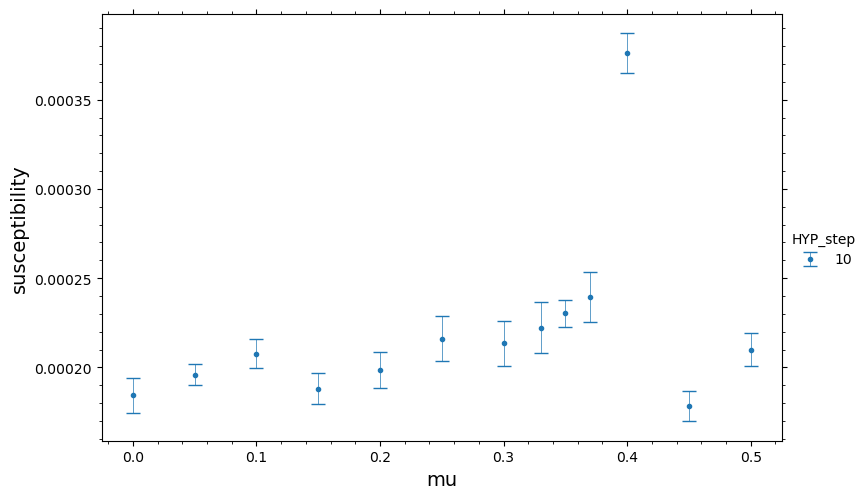

In [ ]:
fm_to_GeV = 1/0.197327
a = 0.044 * fm_to_GeV / 1000
df = []
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/40^4/mu0.00/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/40^4/mu0.05/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0.05
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/40^4/mu0.10/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0.10
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/40^4/mu0.15/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0.15
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/40^4/mu0.20/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0.20
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/40^4/mu0.25/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0.25
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/40^4/mu0.30/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0.30
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/40^4/mu0.33/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0.33
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/40^4/mu0.35/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0.35
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/40^4/mu0.37/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0.37
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/40^4/mu0.40/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0.40
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/40^4/mu0.45/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0.45
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/40^4/mu0.50/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0.50
df = pd.concat(df)
df = df[df['HYP_step'] == 10]
# df['T'] = 1 / a / df['Nt']
print(df)
fg = seaborn.FacetGrid(data=df, hue='HYP_step', height=5,
                           aspect=1.6, legend_out=True)
fg.map(plt.errorbar, 'mu', 'susceptibility', 'susceptibility_err', mfc=None, fmt='o', ms=3, capsize=5, lw=0.5, ls=None
           ).add_legend()
fg.ax.set_xlabel('mu', fontsize=14)
fg.ax.set_ylabel('susceptibility', fontsize=14)
fg.ax.spines['right'].set_visible(True)
fg.ax.spines['top'].set_visible(True)
fg.ax.minorticks_on()
fg.ax.tick_params(which='both', bottom=True,
                  top=True, left=True, right=True)

    HYP_step  polyakov_loop  polyakov_loop_err  susceptibility  \
10        10       0.004996           0.000529        0.000769   
10        10       0.063676           0.001199        0.001182   
10        10       0.125945           0.000951        0.000728   
10        10       0.238337           0.000623        0.000464   

    susceptibility_err    mu  
10            0.000024  0.00  
10            0.000068  0.25  
10            0.000037  0.30  
10            0.000020  0.40  


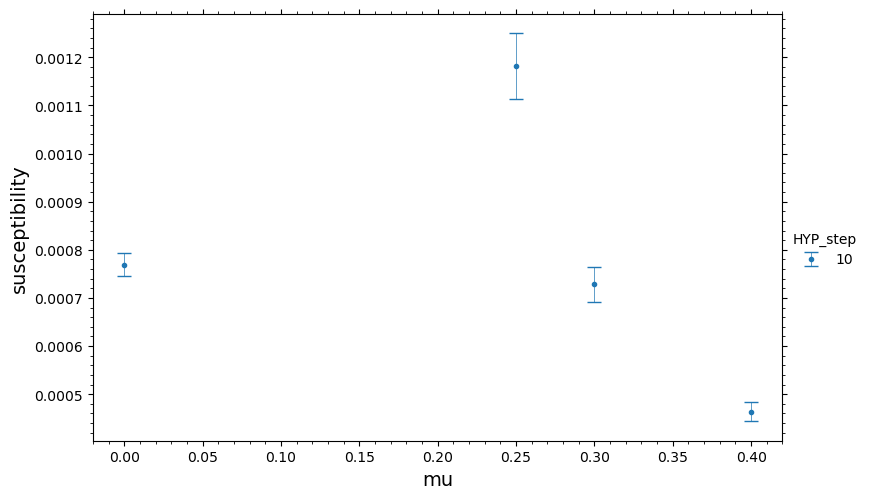

In [ ]:
fm_to_GeV = 1/0.197327
a = 0.044 * fm_to_GeV / 1000
df = []
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^4/mu0.00/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^4/mu0.25/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0.25
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^4/mu0.30/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0.30
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^4/mu0.40/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0.40

df = pd.concat(df)
df = df[df['HYP_step'] == 10]
# df['T'] = 1 / a / df['Nt']
print(df)
fg = seaborn.FacetGrid(data=df, hue='HYP_step', height=5,
                           aspect=1.6, legend_out=True)
fg.map(plt.errorbar, 'mu', 'susceptibility', 'susceptibility_err', mfc=None, fmt='o', ms=3, capsize=5, lw=0.5, ls=None
           ).add_legend()
fg.ax.set_xlabel('mu', fontsize=14)
fg.ax.set_ylabel('susceptibility', fontsize=14)
fg.ax.spines['right'].set_visible(True)
fg.ax.spines['top'].set_visible(True)
fg.ax.minorticks_on()
fg.ax.tick_params(which='both', bottom=True,
                  top=True, left=True, right=True)

    HYP_step  polyakov_loop  polyakov_loop_err  susceptibility  \
10        10       0.002224           0.000477        0.000150   
10        10       0.002101           0.000357        0.000160   
10        10       0.003512           0.000468        0.000177   

    susceptibility_err   mu  
10            0.000008  0.1  
10            0.000007  0.3  
10            0.000008  0.4  


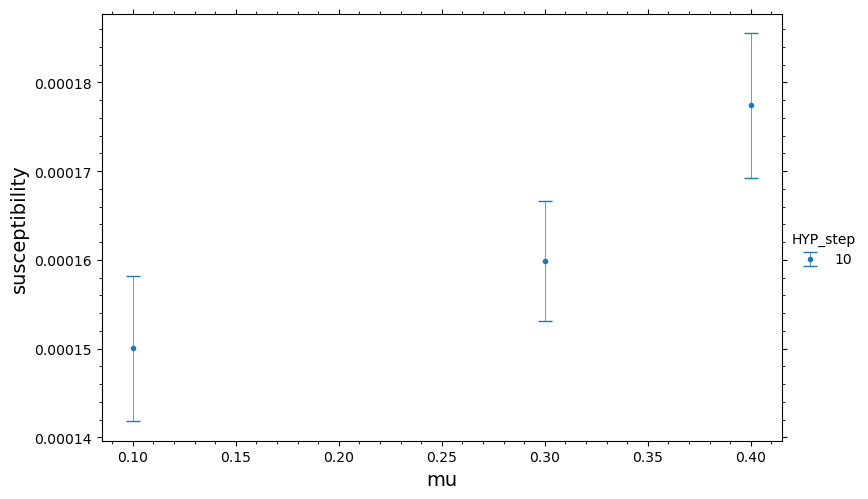

In [ ]:
fm_to_GeV = 1/0.197327
a = 0.044 * fm_to_GeV / 1000
df = []
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x64/mu0.10/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0.1
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x64/mu0.30/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0.30
df.append(pd.read_csv('../../result/smearing/polyakov_loop/su2/qc2dstag/32^3x64/mu0.40/original/HYP10_alpha=1_1_0.5/polyakov_loop.csv'))
df[-1]['mu'] = 0.40

df = pd.concat(df)
df = df[df['HYP_step'] == 10]
# df['T'] = 1 / a / df['Nt']
print(df)
fg = seaborn.FacetGrid(data=df, hue='HYP_step', height=5,
                           aspect=1.6, legend_out=True)
fg.map(plt.errorbar, 'mu', 'susceptibility', 'susceptibility_err', mfc=None, fmt='o', ms=3, capsize=5, lw=0.5, ls=None
           ).add_legend()
fg.ax.set_xlabel('mu', fontsize=14)
fg.ax.set_ylabel('susceptibility', fontsize=14)
fg.ax.spines['right'].set_visible(True)
fg.ax.spines['top'].set_visible(True)
fg.ax.minorticks_on()
fg.ax.tick_params(which='both', bottom=True,
                  top=True, left=True, right=True)